In [1]:
%%capture
import sys
import math
import random
import pickle
import matplotlib
import pandas as pd
import numpy as np
#import datetime
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import regex as re
#from numpy import *
from scipy import stats
from scipy.stats import ttest_1samp
from datetime import timedelta, datetime, time, date
from statsmodels.regression.linear_model import RegressionResults
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import rc
from tqdm.notebook import tqdm
from cycler import cycler
tqdm().pandas()

fontsize = 12
rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': fontsize})
rc('text', usetex=True)

color_list = ["#348ABD","#A60628","#7A68A6","#467821","#CF4457","#188487","#E24A33"]
style = {
  "lines.linewidth": 2.0,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 0.5,
  "legend.fancybox": True,
  "axes.prop_cycle": cycler('color', color_list),
  "axes.facecolor": "#ffffff",
  "axes.labelsize": "large",
  "axes.grid": True,
  "patch.edgecolor": "#eeeeee",
  "axes.titlesize": "x-large",
  "svg.fonttype": "path"}

matplotlib.rcParams.update(style)

# Modify pandas display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 30)

data_path       = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Python/Data/"
path_data_files = '/Users/Stefa/Documents/Sentiment Analysis Files/'

extended_model_path = data_path+'Classification/DagoBERT/SCE_Loss_minw_25_lr_5e5_3ep_bs32_wd_1e2_a0_5_b3_NN1_w2v_topics/' 
extended_data_path  = path_data_files+'filtered_news_data_for_transformer/train_validation_data' #data_with_922_constituents/train_validation_data/'

output_path   = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/"
fin_data_path = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Financial Data/"    


def load_data(file):
    df = pd.read_csv(file, encoding='utf-8-sig')
    df.Date = pd.to_datetime(df.Date)
    df = df.set_index(['Ticker', 'Date'])
    df = df.rename(columns={'Prediction value': 'prediction_value'})
    return df


## Filter for topics
def filter_topic(data, topic):
    print('Topic:', topic)
    return data[data[topic] > 0] 


def t_test(sample, parent):
    mu = np.mean(parent)
    t_value = (np.mean(sample)-mu)/(np.std(sample)/np.sqrt(sample.shape[0]))
    return t_value  


def get_zscores(x, idiosync_z_scores, rw=int(255/2)):
    idiosync = '_idiosync' if idiosync_z_scores else ''
    
    r = x.rolling(window=rw, closed='left', min_periods=int(0.9*rw))
    m = r.mean()
    s = r.std()
    z = (x-m)/s
    z.index.name = 'Date'    
    return z



# Filer for Industries
constituents = pd.read_csv(data_path+'label_counts.csv')
sectors = constituents.ICBIN.unique()

confidence_levels = {0.9:1.645, 0.95:1.96, 0.96:2.05, 0.98:2.33, 0.99:2.58}

## Preprocessing

In [ ]:
# Remove duplicate news items 
# News published between 4pm am 12am are merged into one document and news published between
# 12am an p:30am are merged into a seperate document. Thus there can exist two seperate overnight 
# news documents of one company. This skript removes duplicates and calculates the mean of the sentiment 
# of two news articles.

# Load News Events Data
news_event_df = pd.read_csv(data_path+'news_event_df.csv', encoding='utf-8')
news_event_df.Timestamp_ET = pd.DatetimeIndex(news_event_df.Timestamp_ET)
news_event_df.Date = pd.to_datetime(news_event_df.Date)
news_event_df = news_event_df.set_index(['Timestamp_ET', 'Ticker'])

cols = ['Ticker', 'Sentiment', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'neutral', 'negative', 'positive', 'Prediction', 'Prediction value']
dates = np.unique(test_data_pred.index.get_level_values(0).date) 

for i in tqdm(range(1, len(dates)-1)):
    date = dates[i]
    c = datetime.combine(dates[i-1], time(16,0))
    o = datetime.combine(dates[i],   time(9,30))
    
    not_duplicated = news_event_df.loc[c:o, cols].loc[news_event_df.loc[c:o, 'Ticker'].duplicated(keep=False)==False].reset_index(drop=True)
    duplicated     = news_event_df.loc[c:o, :].loc[news_event_df.loc[c:o, 'Ticker'].duplicated(keep=False)].groupby('Ticker').mean().reset_index()
    
    not_duplicated['Date'] = dates[i]
    duplicated['Date']     = dates[i]
    not_duplicated['prev_close_date'] = dates[i-1]
    duplicated['prev_close_date']     = dates[i-1]    
    
    if i == 1:
        news_event_df_no_dupl = pd.concat([not_duplicated, duplicated], axis=0)
    else:
        news_event_df_no_dupl = pd.concat([news_event_df_no_dupl, not_duplicated, duplicated], axis=0)
        
        
news_event_df_no_dupl = news_event_df_no_dupl.reset_index(drop=True)
news_event_df_no_dupl.to_csv(data_path+'news_event_df_no_dupl.csv', encoding='utf-8')

  0%|          | 0/4524 [00:00<?, ?it/s]

In [21]:
news_event_df

,Ticker,Sentiment,topic_1,topic_2,topic_3,topic_4,neutral,negative,positive,Prediction,Prediction value,Date,prev_close_date
0,MET,1.0,0.000000,0.237069,0.0,0.0,0.834892,0.019216,0.145892,0.0,0.126676,2002-01-04,2002-01-03
1,AZO,1.0,0.000000,0.000000,0.0,0.0,0.968483,0.016149,0.015368,0.0,-0.000782,2002-01-04,2002-01-03
2,ROK,0.0,0.000000,0.168103,0.0,0.0,0.028091,0.021007,0.950902,2.0,0.929895,2002-01-04,2002-01-03
3,BAX,0.0,0.000000,0.000000,0.0,0.0,0.955340,0.024892,0.019768,0.0,-0.005124,2002-01-04,2002-01-03
4,TUP,0.0,0.000000,0.000000,0.0,0.0,0.979820,0.008531,0.011649,0.0,0.003118,2002-01-04,2002-01-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164736,GILD,2.0,0.000000,0.000000,0.0,0.0,0.499749,0.005374,0.494877,1.0,0.489503,2020-02-27,2020-02-26
164737,MAR,1.0,0.101724,0.357759,0.0,0.0,0.004889,0.987755,0.007356,1.0,-0.980399,2020-02-27,2020-02-26
164738,MMM,2.0,0.096552,0.099138,0.0,0.0,0.494229,0.011994,0.493777,1.0,0.481782,2020-02-27,2020-02-26
164739,MSFT,2.0,0.000000,0.101293,0.0,0.0,0.489590,0.502526,0.007884,0.5,-0.494642,2020-02-27,2020-02-26


In [165]:
RIC = pd.read_csv(data_path + 'return_data_moo.csv', index_col=0)  

RC = pd.read_csv(data_path+'sp500_constituents_return_open.csv', encoding='utf-8', index_col=0)

In [166]:
df = pd.merge(left=RIC.JNJ, right=RC.JNJ, left_index=True, right_index=True)
df.columns = ['RIC', 'RC']

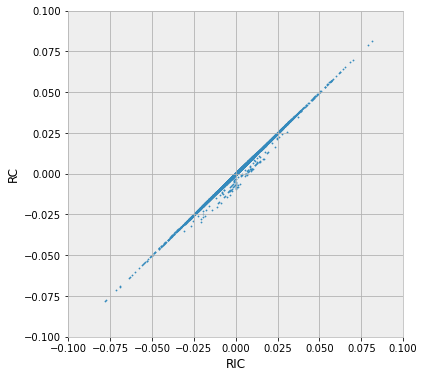

In [167]:
fix, ax = plt.subplots(figsize=(6,6))
df.plot.scatter(x='RIC', y='RC', s=1.5, ax=ax)
plt.xlim(-0.1,0.1)
plt.ylim(-0.1,0.1)
plt.show()

### Load Data

In [58]:
no_dupl = True   # load news events without duplicates

r_cols = ['return_t_V', 'return_t_IV', 'return_t_III', 'return_t_II', 'return_t_I', 
                     'return_t', 'return_t_1', 'return_t_2', 'return_t_3', 'return_t_4', 
                     'return_t_5', 'return_t_6', 'return_t_7', 'return_t_8']

z_cols = ['z_value_t_III', 'z_value_t_II', 'z_value_t_I', 'z_value_t', 'z_value_t_1']

# Load News Events Data
if no_dupl:
    news_event_df = pd.read_csv(data_path+'news_event_df_no_dupl.csv', encoding='utf-8', index_col=0)
    news_event_df.Date = pd.to_datetime(news_event_df.Date)
    news_event_df = news_event_df.set_index(['Date', 'Ticker']) 
    
else:
    news_event_df = pd.read_csv(data_path+'news_event_df.csv', encoding='utf-8')
    news_event_df.Timestamp_ET = pd.DatetimeIndex(news_event_df.Timestamp_ET)
    news_event_df.Date = pd.to_datetime(news_event_df.Date)
    news_event_df = news_event_df.set_index(['Timestamp_ET', 'Ticker'])


# Return data of all constituents (file reference: Stock Return Calculation.ipynb)     # return_data_moo
asset_returns = pd.read_csv(data_path + 'return_mo_to_mc.csv', index_col=0)            # return_data_moc 
asset_returns.index = pd.to_datetime(asset_returns.index)                              # return_mo_to_mc                          
asset_returns = asset_returns.replace([np.inf, -np.inf, 0.00000], np.nan)              # return_mc_to_mo
asset_returns = asset_returns[asset_returns.apply(lambda x: sum(x.isna()), axis=1) < 0.8*asset_returns.shape[1]] # Drop rows with more than 80% NaN values
return_data = asset_returns.loc[news_event_df.index.get_level_values(0)[0]-timedelta(days=1) : news_event_df.index.get_level_values(0)[-1]]

# Load Beta values (file reference: Volatility adjusted labels.ipynb)
beta = pd.read_csv(data_path+'beta_moc_df.csv')     
beta.Date = pd.to_datetime(beta.Date)
#beta = beta[beta['Date'].dt.year >= 2002]
beta = beta[beta['Date'].dt.year <= 2020]
beta = beta.set_index('Date')
beta.head()
                                        
Ticker_inSP = pd.read_csv(data_path+'Ticker_inSP_2020.csv', index_col=0)
Ticker_inSP.index = pd.to_datetime(Ticker_inSP.index)
dates_daily_freq = pd.date_range(start=datetime(2002,1,1), end=datetime(2020,2,28), freq='D').to_frame().loc[:, []]
Ticker_inSP_adj  = pd.merge_asof(left=dates_daily_freq, right=Ticker_inSP, left_index=True, right_index=True, direction='backward')

#sp500 = pd.read_csv(fin_data_path+'SP500_Open_Close_Data_2002_2022.csv', encoding='utf-8', index_col=0)
sp500 = pd.read_csv(fin_data_path+'SP500_Open_Close_Data_1994_2022.csv', encoding='utf-8', sep=';')
sp500['Date'] = pd.to_datetime(sp500['Date']) 
sp500 = sp500.set_index('Date')
sp500['Total Return Open'] = (sp500.Open/sp500.Close)*sp500['Total Return']
sp500_r = sp500.pct_change()  # Daily Returns
sp500_r['TR OpenClose'] = (sp500['Total Return']-sp500['Total Return Open'])/sp500['Total Return Open']
sp500_r['TR CloseOpen'] = (sp500['Total Return Open'] - sp500['Total Return'].shift(1))/sp500['Total Return'].shift(1)

rf_3M = pd.read_csv(data_path+'rf_3M.csv')
rf_3M.Date = pd.to_datetime(rf_3M.Date)
rf_3M = rf_3M.set_index('Date')
rf_3M = rf_3M.rename(columns={'Value': 'rf_rate'})
rf_3M = pd.merge_asof(left=sp500.loc[:, []], right=rf_3M, left_index=True, right_index=True, direction='backward')

In [59]:
news_event_df

Sentiment   topic_1   topic_2  topic_3  topic_4   neutral  \
Date       Ticker                                                              
2002-01-04 MET           1.0  0.000000  0.237069      0.0      0.0  0.834892   
           AZO           1.0  0.000000  0.000000      0.0      0.0  0.968483   
           ROK           0.0  0.000000  0.168103      0.0      0.0  0.028091   
           BAX           0.0  0.000000  0.000000      0.0      0.0  0.955340   
           TUP           0.0  0.000000  0.000000      0.0      0.0  0.979820   
...                      ...       ...       ...      ...      ...       ...   
2020-02-27 GILD          2.0  0.000000  0.000000      0.0      0.0  0.499749   
           MAR           1.0  0.101724  0.357759      0.0      0.0  0.004889   
           MMM           2.0  0.096552  0.099138      0.0      0.0  0.494229   
           MSFT          2.0  0.000000  0.101293      0.0      0.0  0.489590   
           XOM           0.5  0.000000  0.000000      0.0      0.0  0.983518   

                   negative  positive  Prediction  Prediction value  \
Date       Ticker                                                     
2002-01-04 MET     0.019216  0.145892         0.0          0.126676   
           AZO     0.016149  0.015368         0.0         -0.000782   
           ROK     0.021007  0.950902         2.0          0.929895   
           BAX     0.024892  0.019768         0.0         -0.005124   
           TUP     0.008531  0.011649         0.0          0.003118   
...                     ...       ...         ...               ...   
2020-02-27 GILD    0.005374  0.494877         1.0          0.489503   
           MAR     0.987755  0.007356         1.0         -0.980399   
           MMM     0.011994  0.493777         1.0          0.481782   
           MSFT    0.502526  0.007884         0.5         -0.494642   
           XOM     0.009393  0.007089         0.0         -0.002305   

                  prev_close_date  
Date       Ticker                  
2002-01-04 MET         2002-01-03  
           AZO         2002-01-03  
           ROK         2002-01-03  
           BAX         2002-01-03  
           TUP         2002-01-03  
...                           ...  
2020-02-27 GILD        2020-02-26  
           MAR         2020-02-26  
           MMM         2020-02-26  
           MSFT        2020-02-26  
           XOM         2020-02-26  

[164741 rows x 11 columns]

In [43]:
sp500_r.head()

,Total Return,Price Index,Open,Close,Total Return Open,TR OpenClose,TR CloseOpen
Date,,,,,,,
1993-12-31,NaN,NaN,NaN,NaN,NaN,0.007075,NaN
1994-01-03,0.007042,0.006967,0.007075,0.007025,0.007091,0.007025,0.000017
1994-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.007025,-0.006976
1994-01-05,-0.020977,-0.020757,0.000000,-0.020972,-0.000005,-0.014095,-0.006981
1994-01-06,-0.057150,-0.057357,-0.028144,-0.057139,-0.028156,-0.043508,-0.014262


In [44]:
# Calculate idiosyncratic returns
# r_idiosync = r_j - r_f - beta(j, t-1)* (r_SP500(t) - r_f)

trade_time = 'MOC_MOO'

def capm_expected_returns(beta_i):
    if trade_time == 'MOC':
        expected_return = expected_returns.rf_rate + beta_i * (expected_returns['Total Return'] - expected_returns.rf_rate)
    elif trade_time == 'MOO':
        expected_return = expected_returns.rf_rate + beta_i * (expected_returns['Total Return Open']  - expected_returns.rf_rate)
    elif trade_time == 'MOO_MOC':
        expected_return = expected_returns.rf_rate + beta_i * (expected_returns['TR OpenClose'] - expected_returns.rf_rate)    
    elif trade_time == 'MOC_MOO':
        expected_return = expected_returns.rf_rate + beta_i * (expected_returns['TR CloseOpen'] - expected_returns.rf_rate)                  
    return expected_return


if trade_time   == 'MOC':
    expected_returns = pd.merge(left=beta.shift(periods=1), right=sp500_r['Total Return'], left_index=True, right_index=True)
elif trade_time == 'MOO':
    expected_returns = pd.merge(left=beta.shift(periods=1), right=sp500_r['Total Return Open'], left_index=True, right_index=True)
elif trade_time == 'MOO_MOC':   
    expected_returns = pd.merge(left=beta.shift(periods=1), right=sp500_r['TR OpenClose'],  left_index=True, right_index=True)
elif trade_time == 'MOC_MOO':
    expected_returns = pd.merge(left=beta.shift(periods=1), right=sp500_r['TR CloseOpen'],  left_index=True, right_index=True)

expected_returns = pd.merge(left=expected_returns, right=rf_3M,  left_index=True, right_index=True)  
expected_returns = expected_returns.loc[:,'MLM':'MU'].apply(capm_expected_returns)
abnormal_returns = asset_returns.loc[expected_returns.index[0]:expected_returns.index[-1]] - expected_returns

#abnormal_returns = abnormal_returns.loc[news_event_df.Date[0]-timedelta(days=1) : news_event_df.Date[-1]]

In [45]:
abnormal_returns.head()

,MLM,TSCO,ALB,QLGC,WAI,AVB,CPRT,AKS,SIND,QTRN,NKTR,LEHMQ,ASND,ESS,GLD,...,CSX,NKE,GL,FITB,INGR,PCP,EC,KATE,HBOC,SGAT,BGEN,HD,IGT,CA,MU
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1993-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.003036,0.002772,-0.002166,-0.004865,0.000554,-0.004550,-0.005131,0.005765,0.005822,NaN,-0.002512,0.000047,-0.004147,-0.002372,0.000089
1994-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.009125,0.016921,0.007743,0.010539,0.011022,0.007851,0.007384,0.009975,0.012615,0.017326,0.030297,0.011074,0.026473,0.023970,0.021017
1994-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.013804,0.016657,0.007734,0.020446,NaN,-0.000820,0.002690,0.009554,0.011355,0.011000,0.007388,0.011068,0.017103,0.026539,0.015568
1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.018738,0.028495,0.012984,0.011623,-0.011264,0.001190,0.009891,0.025545,0.024764,0.032910,0.033846,0.031957,0.023404,0.029393,0.046879


In [171]:
#return_data.to_csv('./Short-term Momentum/asset_returns_mo_to_mo.csv', encoding='utf-8')

In [139]:
idiosync_z_scores = True
idiosync = '_idiosync' if idiosync_z_scores else ''

if idiosync_z_scores:
    z_scores = get_zscores(abnormal_returns, idiosync_z_scores)    
else: 
    z_scores = get_zscores(asset_returns, idiosync_z_scores)    
    
z_scores.to_csv(data_path+f'z_values_mo_to_mo_127d_rw{idiosync}.csv', encoding='utf-8', index=True)

In [46]:
def match_news_with_returns(news_event_df, use_abnormal_returns, z_values, news_window=17.5, order_time='moo'):    
    if use_abnormal_returns:
        return_df = abnormal_returns
    else:
        return_df = return_data
    
    news_window_h   = int(news_window)
    news_window_min = int((news_window % 1)*60)
    dates = list(return_df.index)
    print(len(dates))
    z_values = pd.merge(left=pd.DataFrame(index=dates), right=z_values, left_index=True, right_index=True, how='left')
    
    for i, date in tqdm(enumerate(dates[:-8])):
        if i >= 5:
            if order_time == 'moo':    # Market open order
                rw_end   = datetime.combine(date, time(9,30))
                rw_start = rw_end - timedelta(hours=news_window_h, minutes=news_window_min)
            elif order_time == 'moc':  # Market close order
                rw_end   = datetime.combine(date, time(16,0))
                rw_start = rw_end - timedelta(hours=news_window_h, minutes=news_window_min)                
                                  
            df = news_event_df.loc[((rw_start <= news_event_df.index.get_level_values('Timestamp_ET')) & (news_event_df.index.get_level_values('Timestamp_ET') <= rw_end), slice(None)), :]
            ticker = df.index.get_level_values('Ticker').unique()
                        
            for k, return_k in enumerate(r_cols):
                rk = return_df.loc[dates[i-5+k],  ticker].rename(return_k)
                if k == 0:
                    values = rk
                else:
                    values = pd.concat([values, rk], axis=1)

            for k, zval_k in enumerate(z_cols):
                zk = z_values.loc[dates[i-3+k],  ticker].rename(zval_k)
                values = pd.concat([values, zk], axis=1)
            
            if i == 5:
                new_df = pd.merge(df.reset_index(), values, on='Ticker', how='left')
            else:
                new_df = pd.concat([new_df, pd.merge(df.reset_index(), values, on='Ticker', how='left')])

    return new_df



      
trade_time = 'MOC_MOO'
use_abnormal_returns  = True
idiosync_z_scores     = True
calc_z_vals = False

abn = '_abn' if use_abnormal_returns else '' 
idiosync = '_idiosync' if idiosync_z_scores else ''

if calc_z_vals == True:
    print('Calculate z-values')
    if use_abnormal_returns:
        z_scores = get_zscores(abnormal_returns, idiosync_z_scores)    
    else: 
        z_scores = get_zscores(asset_returns, idiosync_z_scores)   
else:
    print('Load z-values')
    z_scores = pd.read_csv(data_path+f'z_values_mo_to_mo_127d_rw{idiosync}.csv', encoding='utf-8')   # use z-scores from open to open here, z-scores from close to open are added later!
    z_scores.Date = pd.to_datetime(z_scores.Date)                                   
    z_scores = z_scores.set_index('Date')  
    
    
if trade_time == 'MOC':
    # Match news_with_returns
    new_df = match_news_with_returns(news_event_df, use_abnormal_returns, z_scores, news_window=6.5, order_time='moc')  # order_time: 'moc' or 'moo'
    # Save the Data Frame
    new_df.to_csv(extended_model_path+f'train_valid_data_pred_and{abn}_returns_mc_to_mc_6_5h_z_val{idiosync}_fresh_'+str(2002)+'-'+str(2021)+'.csv', encoding='utf-8-sig', index=False)  

    
if trade_time == 'MOO':
    # Match news_with_returns
    new_df = match_news_with_returns(news_event_df, use_abnormal_returns, z_scores, news_window=17.5, order_time='moo')  # order_time: 'moc' or 'moo'
    # Save the Data Frame
    new_df.to_csv(extended_model_path+f'train_valid_data_pred_and{abn}_returns_mo_to_mo_17_5h_z_val{idiosync}_fresh_'+str(2002)+'-'+str(2021)+'.csv', encoding='utf-8-sig', index=False)  
    
    
if trade_time == 'MOO_MOC':
    # Match news_with_returns
    new_df = match_news_with_returns(news_event_df, use_abnormal_returns, z_scores, news_window=17.5, order_time='moo')  # order_time: 'moc' or 'moo'
    # Save the Data Frame
    new_df.to_csv(extended_model_path+f'train_valid_data_pred_and{abn}_returns_mo_to_mc_17_5h_z_val{idiosync}_fresh_'+str(2002)+'-'+str(2021)+'_v2.csv', encoding='utf-8-sig', index=False)
    
    
if trade_time == 'MOC_MOO':
    # Match news_with_returns
    new_df = match_news_with_returns(news_event_df, use_abnormal_returns, z_scores, news_window=17.5, order_time='moo')  # order_time: 'moc' or 'moo'
    # Save the Data Frame
    new_df.to_csv(extended_model_path+f'train_valid_data_pred_and{abn}_returns_mc_to_mo_17_5h_z_val{idiosync}_fresh_'+str(2002)+'-'+str(2021)+'_v2.csv', encoding='utf-8-sig', index=False)  

Load z-values
7016


0it [00:00, ?it/s]

In [146]:
new_df.head(2)

,Ticker,Timestamp_ET,Date,News,Sentiment,freshness,topic_1,topic_2,topic_3,topic_4,neutral,negative,positive,Prediction,Prediction value,...,return_t_I,return_t,return_t_1,return_t_2,return_t_3,return_t_4,return_t_5,return_t_6,return_t_7,return_t_8,z_value_t_III,z_value_t_II,z_value_t_I,z_value_t,z_value_t_1
0,SUN,2002-01-03 00:09:28.021,2002-01-03,suncorp raises mln in share plan brisbane jan ...,0.0,fresh,0.0,0.189655,0.0,0.0,0.916798,0.024531,0.058671,0,0.034140,...,0.000609,0.001259,-0.002892,0.013767,-0.010606,0.022384,0.011201,-0.002328,-0.001233,0.026318,-0.223266,NaN,-0.535515,-0.082636,-0.005171
1,SIAL,2002-01-03 02:00:25.322,2002-01-03,sia rises on nov loads bargain hunting singapo...,0.0,fresh,0.0,0.172414,0.0,0.0,0.976509,0.010941,0.012550,0,0.001609,...,0.005205,0.013608,0.009283,0.008622,-0.015808,-0.031935,0.021925,0.005488,-0.003407,0.026137,0.028421,NaN,-0.804419,0.190574,0.415270


In [148]:
news_event_df = load_data(extended_model_path+'train_valid_data_pred_and_abn_returns_mo_to_mc_17_5h_z_val_idiosync_fresh_'+str(2002)+'-'+str(2021)+'_v2.csv')

In [8]:
# Load the Data Frame 
#a) train_valid_data_inkl_pred_and_abn_returns_z_val_timestamp_fresh_SCE_NN1_w2v_topics_2002-2021.csv      # abnormal returns MOO 17.5h
#b) train_valid_data_inkl_pred_and_returns_moo17_5h_z_val_timestamp_fresh_SCE_NN1_w2v_topics_2002-2021.csv #          returns MOO 17.5h
#c) train_valid_data_inkl_pred_and_returns_moc24h_z_val_timestamp_fresh_SCE_NN1_w2v_topics_2002-2021.csv   #          returns MOC 24h  
#d) train_valid_data_inkl_pred_and_returns_moc6_5h_z_val_timestamp_fresh_SCE_NN1_w2v_topics_2002-2021.csv  #          returns MOC 6.5h  

test_data_pred = load_data(extended_model_path+'train_valid_data_pred_and_abn_returns_mo_to_mc_17_5h_z_val_idiosync_fresh_'+str(2002)+'-'+str(2021)+'_v2.csv')
#test_data_pred.Date = pd.to_datetime(test_data_pred.Date)
#test_data_pred = test_data_pred.set_index(['Ticker', 'Date'])
print(test_data_pred.shape)
test_data_pred.head(2)

(169872, 33)


,,Timestamp_ET,News,Sentiment,freshness,topic_1,topic_2,topic_3,topic_4,neutral,negative,positive,Prediction,prediction_value,TradingDate,return_t_V,...,return_t_I,return_t,return_t_1,return_t_2,return_t_3,return_t_4,return_t_5,return_t_6,return_t_7,return_t_8,z_value_t_III,z_value_t_II,z_value_t_I,z_value_t,z_value_t_1
Ticker,Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SUN,2002-01-03,2002-01-03 00:09:28.021,suncorp raises mln in share plan brisbane jan ...,0.0,fresh,0.0,0.189655,0.0,0.0,0.916798,0.024531,0.058671,0,0.034140,2002-01-03,-0.015259,...,0.000609,0.001259,-0.002892,0.013767,-0.010606,0.022384,0.011201,-0.002328,-0.001233,0.026318,-0.223266,NaN,-0.535515,-0.082636,-0.005171
SIAL,2002-01-03,2002-01-03 02:00:25.322,sia rises on nov loads bargain hunting singapo...,0.0,fresh,0.0,0.172414,0.0,0.0,0.976509,0.010941,0.012550,0,0.001609,2002-01-03,NaN,...,0.005205,0.013608,0.009283,0.008622,-0.015808,-0.031935,0.021925,0.005488,-0.003407,0.026137,0.028421,NaN,-0.804419,0.190574,0.415270


## 
## Classification Report

In [34]:
year, intervall = 2002, 18
return_t_n = 'return_t'
confidence = 0.95

df = test_data_pred.copy()
df = df.loc[(year <= df.index.get_level_values('Date').year) & (df.index.get_level_values('Date').year <= year+intervall), :]

sub_df = df.dropna()   # drop NaNs

## Filter for topics 
sub_df = filter_topic(sub_df, topic='topic_1')
#######################

## Filter for z-values 
sub_df = sub_df[((sub_df['z_value_t'] < -1.96) & (sub_df['Prediction'] == 1)) | (sub_df['Prediction'] == 2)  | (sub_df['Prediction'] == 0)]
#sub_df = sub_df[((sub_df['z_value_t'] < -1.96) & (sub_df['Prediction'] == 1)) | (sub_df['Prediction'] == 2)]
#########################

#sub_df = sub_df.loc[sub_df.freshness == 'fresh', :]          # select fresh articles
sub_df = sub_df.loc[abs(sub_df.prediction_value) >= 0.95, :]  # control prediction confidence
sub_df = sub_df.reset_index()

sub_df['true_pos']  = 0
sub_df['false_pos'] = 0
sub_df['true_neg']  = 0
sub_df['false_neg'] = 0
sub_df['y_true']    = np.nan

sub_df.loc[sub_df[return_t_n] > 0, 'y_true'] = 2
sub_df.loc[sub_df[return_t_n] < 0, 'y_true'] = 1

def get_direction(prediction_val):
    if prediction_val > confidence:
        return 2
    elif prediction_val <-confidence:
        return 1
    else:
        return 0

sub_df['predict_direction'] = sub_df.prediction_value.apply(get_direction)
up_down_predictions = sub_df[['predict_direction', 'y_true']].dropna()

# Calculate precision and recall manually
sub_df.loc[(sub_df.prediction_value > confidence) & (sub_df[return_t_n] > 0), 'true_pos']  = 1
sub_df.loc[(sub_df.prediction_value > confidence) & (sub_df[return_t_n] < 0), 'false_pos'] = 1
sub_df.loc[(sub_df.prediction_value <-confidence) & (sub_df[return_t_n] < 0), 'true_neg']  = 1
sub_df.loc[(sub_df.prediction_value <-confidence) & (sub_df[return_t_n] > 0), 'false_neg'] = 1

precision = round(sum(sub_df['true_pos'])/(sum(sub_df['true_pos'])+sum(sub_df['false_pos'])),4)
recall    = round(sum(sub_df['true_pos'])/sum(sub_df[return_t_n] > 0),4)
print(f'Positive Predictions: Precision: {precision}, Recall: {recall}')
precision = round(sum(sub_df['true_neg'])/(sum(sub_df['true_neg'])+sum(sub_df['false_neg'])),4)
recall    = round(sum(sub_df['true_neg'])/sum(sub_df[return_t_n] < 0),4)
print(f'Negative Predictions: Precision: {precision}, Recall: {recall}')

Topic: topic_1
Positive Predictions: Precision: 0.512, Recall: 0.8289
Negative Predictions: Precision: 0.5224, Recall: 0.1915


In [35]:
print(classification_report(up_down_predictions.y_true, up_down_predictions.predict_direction, zero_division=0))

              precision    recall  f1-score   support

         1.0       0.52      0.19      0.28      4866
         2.0       0.51      0.83      0.63      4979

    accuracy                           0.51      9845
   macro avg       0.52      0.51      0.46      9845
weighted avg       0.52      0.51      0.46      9845



In [334]:
# Average Return for pos. and neg. predictions
# With w2v Topics and cleand data (no numbers and punctuation marks):
annual = True
print('Return:', return_t_n)
if annual == True:
    d, s = 252, 'p.a.'
else:
    d, s = 1,   'p.d.'

pos_mean_return = sub_df.loc[sub_df.prediction_value >= confidence, return_t_n].mean()*d
neg_mean_return = sub_df.loc[sub_df.prediction_value <-confidence, return_t_n].mean()*d
all_mean_return = df.loc[:, return_t_n].mean()*d
#all_mean_return = sub_df.loc[(sub_df.prediction_value >= confidence) | (sub_df.prediction_value <-confidence), return_t_n].mean()*d

print(f'Mean return (pos. predictions):  {round(100*pos_mean_return,3)}% {s}')
print(f'Mean return (neg. predictions): { round(100*neg_mean_return,3)}% {s}')
print(f'Mean return (all. news):         { round(100*all_mean_return,3)}% {s}')

print(f'delta pos.:  {round(100*(pos_mean_return-all_mean_return),3)}% {s}')
print(f'delta neg.: {round(100*(neg_mean_return-all_mean_return),3)}% {s}')

print(f't-test pos.:  {round(t_test(sample=sub_df.loc[sub_df.prediction_value >= confidence, return_t_n], parent=sub_df.loc[:, return_t_n]),3)}')
print(f't-test neg.: {round(t_test(sample=sub_df.loc[sub_df.prediction_value <- confidence, return_t_n], parent=sub_df.loc[:, return_t_n]),3)}')

# print benchmark accuracy when making random guessing
pos_return = sub_df.loc[sub_df[return_t_n] > 0, return_t_n]
neg_return = sub_df.loc[sub_df[return_t_n] < 0, return_t_n]
observations = sub_df.shape[0]
print("\nBaselines:")
print(f"Return is positive in {round(100*len(pos_return)/observations,3)}% of the time")
print(f"Return is negative in {round(100*len(neg_return)/observations,3)}% of the time")

Return: return_t_1
Mean return (pos. predictions):  25.905% p.a.
Mean return (neg. predictions): -50.881% p.a.
Mean return (all. news):         7.129% p.a.
delta pos.:  18.776% p.a.
delta neg.: -58.01% p.a.
t-test pos.:  1.968
t-test neg.: -2.675

Baselines:
Return is positive in 49.985% of the time
Return is negative in 50.015% of the time


### 
### Average returns after news events

In [335]:
start, end, intervall = 2002, 2021, 3
periodic_data = {}
observations  = {}
freshness     = ['fresh', 'stale', 'all']

df = test_data_pred.copy()

## Filter for topics ##
#df = filter_topic(df, topic='topic_1')
#######################

## Filter for z-values ##
df = df[((df['z_value_t'] < -1.645) & (df['Prediction'] == 1)) | (df['Prediction'] == 2)]
#########################

df = df.loc[abs(df.prediction_value) >= 0.95, :]  # control prediction confidence

for f in freshness:
    periodic_data[f] = {}
    observations[f]  = {}
    
    if f == 'all':
        sub_df = df
    else:
        sub_df = df.loc[df.freshness == f, :]          # select fresh, stale articles

    for i, year in enumerate(range(start, end, intervall)):
        periodic_returns = pd.DataFrame(data={}, columns=r_cols, index=['pos', 'neg', 'all'])
        df_y = sub_df.loc[(year <= sub_df.index.get_level_values('Date').year) & (sub_df.index.get_level_values('Date').year < year+intervall), :]

        for return_t_n in r_cols:
            periodic_returns.loc['pos', return_t_n] = df_y[df_y.Prediction == 2][return_t_n].mean()*252
            periodic_returns.loc['neg', return_t_n] = df_y[df_y.Prediction == 1][return_t_n].mean()*252
            periodic_returns.loc['all', return_t_n] = df_y[return_t_n].mean()*252
        periodic_data[f][str(year)+'-'+str(year+intervall)] = periodic_returns
        observations[f][str(year)+'-'+str(year+intervall)]    = df_y.shape[0]

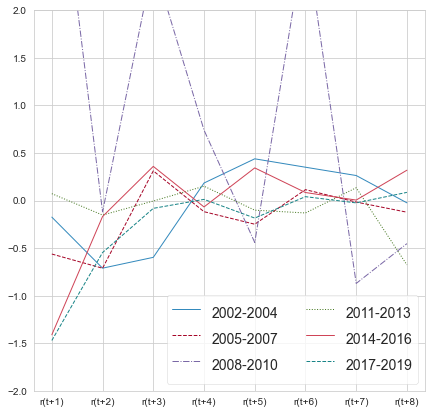

In [336]:
x_values = ['r(t+1)', 'r(t+2)', 'r(t+3)', 'r(t+4)', 'r(t+5)', 'r(t+6)', 'r(t+7)', 'r(t+8)']
sns.set_style('whitegrid')

#from matplotlib import rc
#fontsize = 14
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': fontsize})
#rc('text', usetex=False)

linestyles = {1:'-', 2:'--', 3:'-.', 4:':', 5:'-', 6:'--', 7:'-.', 8:':', 9:'-', 10:'--', 11:'-.', 12:':', 13:'-', 14:'--', 15:'-.', 16:':', 17:'-.', 18:':'}

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7,7))
plt.subplots_adjust(hspace = 0.4)

polarity  = {'neg':'r'}      # 'pos':'b', 'neg':'r', 'all':'g'   (inkl. colors)
freshness = {'fresh':'b'}    # 'fresh':'b', 'stale':'r', 'all':'g'


for i, year in enumerate(range(start, end, intervall)):
    if year+intervall > end:
        break
    for p in polarity.keys():
        for f in freshness.keys():
            axs.plot(x_values, periodic_data[f][str(year)+'-'+str(year+intervall)].loc[p, 'return_t_1':'return_t_8'], linewidth=1.0, label=str(year)+'-'+str(year+intervall-1), linestyle=linestyles[i+1])
    #axs.set_title(str(year)+'-'+str(year+intervall))   
    axs.legend()  
    #axs.set_xlabel(str(f"(Based on {observations[f][str(year)+'-'+str(year+intervall)]} observations)"), labelpad=10)
    plt.ylim(-2.0, 2.0)
    plt.legend(fontsize=14, ncol=2,handleheight=2.4, labelspacing=0.05, loc='lower right')

#plt.savefig('C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/Bilder/event_study_2002_2020_pos_fresh_2y_intervall.pdf', bbox_inches='tight')
plt.show()

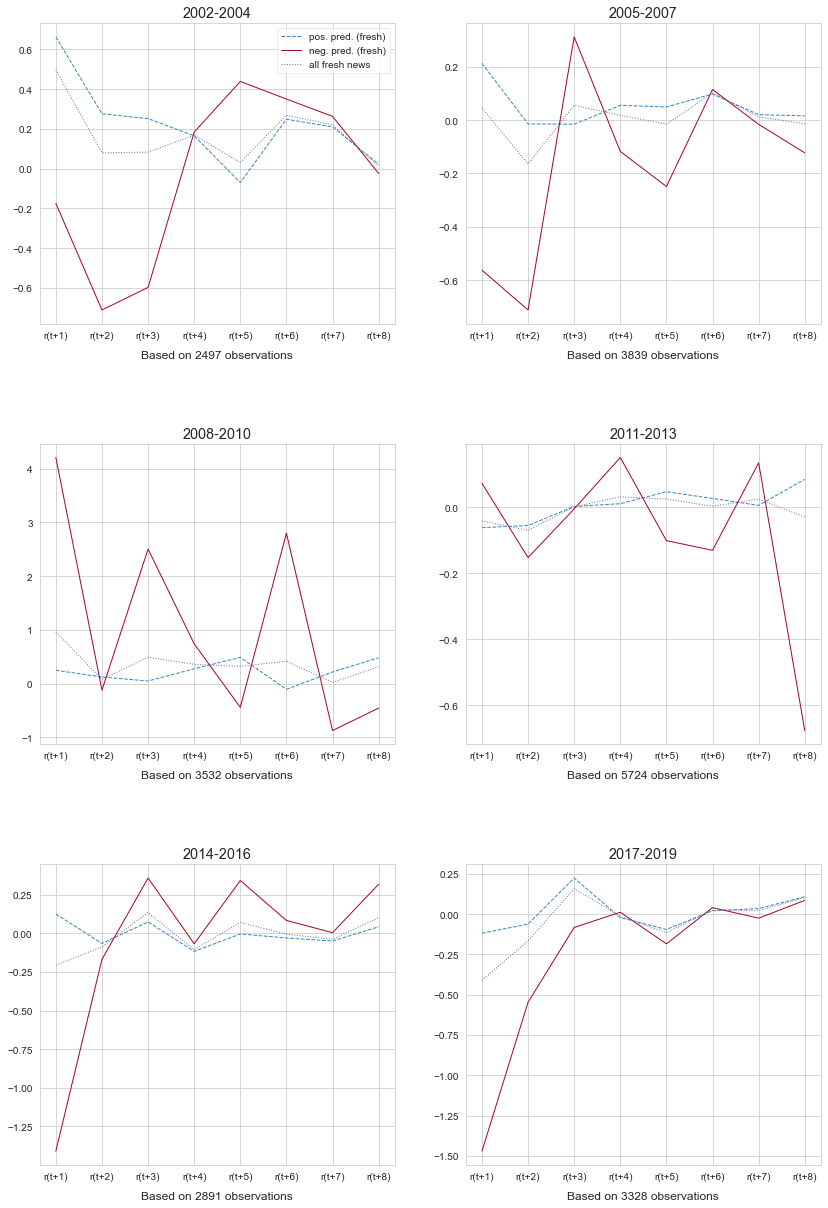

In [337]:
x_values = ['r(t+1)', 'r(t+2)', 'r(t+3)', 'r(t+4)', 'r(t+5)', 'r(t+6)', 'r(t+7)', 'r(t+8)']
sns.set_style('whitegrid')

#plt.rcParams.update({'font.size': 14})
#fontsize = 14
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': fontsize})
#rc('text', usetex=True)

plots = int((end-start)/intervall)
if plots == 1:
    nrow, ncol = 1,1
else:
    nrow, ncol = math.ceil(plots/2), 2 
    
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*7,nrow*7))
plt.subplots_adjust(hspace = 0.4)
k = -1

polarity  = {'pos':'b', 'neg':'r', 'all':'g'}      # 'pos':'b', 'neg':'r', 'all':'g'   (inkl. colors)
freshness = {'fresh':'b'}                          # 'fresh':'b', 'stale':'r', 'all':'g'

for i, year in enumerate(range(start, end, intervall)):
    if year+intervall > end:
        break
    if nrow > 1:
        if (i+1)%2 == 0:
            l = 1
        else:
            l =  0
            k += 1
        for p in polarity.keys():
            for f in freshness.keys():
                if p == 'all':
                    line = 'dotted'
                    if f == 'all':
                        label_str = 'all news'
                    else:
                        label_str = f"all {f} news"
                else:
                    if p == 'pos':
                        line='dashed'
                    else:
                        line='solid'
                    if f == 'all':
                        label_str = f"{p}. pred."
                    else:
                        label_str = f"{p}. pred. ({f})"
                axs[k,l].plot(x_values, periodic_data[f][str(year)+'-'+str(year+intervall)].loc[p, 'return_t_1':'return_t_8'], linewidth=1.0, label=label_str, linestyle=line)
        axs[k,l].set_title(str(year)+'-'+str(year+intervall-1))
        if k == 0 and l == 0:
            axs[k,l].legend()  
        #axs[k,l].set_ylim([-2.0, 2.0])
        axs[k,l].set_xlabel(str(f"Based on {observations[f][str(year)+'-'+str(year+intervall)]} observations"), labelpad=10)
    else:
        for p in polarity.keys():
            for f in freshness.keys():
                if p == 'all':
                    line = 'dotted'
                    if f == 'all':
                        label_str = 'all news'
                    else:
                        label_str = f"all {f} news"
                else:
                    if p == 'pos':
                        line='dashed'
                    else:
                        line='solid'
                    if f == 'all':
                        label_str = f"{p}. pred."
                    else:
                        label_str = f"{p}. pred. ({f})"
                axs.plot(x_values, periodic_data[f][str(year)+'-'+str(year+intervall)].loc[p, 'return_t_1':'return_t_8'], linewidth=1.0, label=label_str, linestyle=line)
        axs.set_title(str(year)+'-'+str(year+intervall-1))   
        axs.legend()  
        axs.set_xlabel(str(f"(Based on {observations[f][str(year)+'-'+str(year+intervall)]} observations)"), labelpad=10)
        plt.ylim(-1.0, 0.8)

#plt.savefig('C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/Bilder/event_study_2002_2020_'+list(freshness.keys())[0]+'_barrier_0_95.pdf', bbox_inches='tight')
plt.show()

# 
### Event Study with z-values only (Unconditional)

In [47]:
def z_scores_and_returns(z_values, use_abnormal_returns=False, idiosync_z_scores=False, exclude_conditional=False):    
    if use_abnormal_returns:
        print('Load abnormal returns')
        return_df = abnormal_returns
    else:
        print('Load total returns')
        return_df = asset_returns
        
    if exclude_conditional:
        print('Exclude conditional observations ...')
        for (ticker, date) in tqdm(test_data_pred.index.values):
            z_values.loc[date, ticker] = np.nan
        
    dates    = list(z_values.loc[datetime(2002,1,2):datetime(2020,1,31)].index)
    z_values = z_values.loc[dates]
    z_values = z_values.stack(dropna=False)
    return_df= pd.merge(left=pd.DataFrame(index=dates), right=return_df, left_index=True, right_index=True, how='left')

    
    init = True
    for i, date in tqdm(enumerate(dates[:-10])):
        if i > 4:   
            ticker_in_sp500_t = set(Ticker_inSP_adj.loc[dates[i], :].dropna().values)                
            Z = z_values.loc[dates[i], slice(None)].to_frame(name='z_value').reset_index(level=0)
            Z = Z.loc[list(set(Z.index).intersection(ticker_in_sp500_t))]          # Select only assets that are in the S&P500            
            R = return_df.loc[dates[i-5:i+8+1], Z.index].T
            R.columns = r_cols
            ZR = pd.merge(left=Z, right=R, left_index=True, right_index=True, how='inner')
            if init:
                z_values_returns = ZR
                init=False
            else:
                z_values_returns = pd.concat([z_values_returns, ZR], axis=0)

    # Remove rows where all returns are missing        
    z_values_returns = z_values_returns.loc[z_values_returns[r_cols].isna().sum(axis=1)!=len(r_cols)]        
    
    return z_values_returns




use_abnormal_returns = True
idiosync_z_scores    = True
exclude_conditional  = False
calc_z_vals = False

abn = '_abn' if use_abnormal_returns else '' 
idiosync = '_idiosync' if idiosync_z_scores else ''
excl_cond = '_excl_cond' if exclude_conditional else ''

if calc_z_vals == True:
    print('Calculate z-values')
    if use_abnormal_returns:
        z_scores = get_zscores(abnormal_returns, idiosync_z_scores)    
    else: 
        z_scores = get_zscores(asset_returns, idiosync_z_scores)   
else:
    print('Load z-values')
    z_scores = pd.read_csv(data_path+f'z_values_mo_to_mc_127d_rw{idiosync}.csv', encoding='utf-8')      
    z_scores.Date = pd.to_datetime(z_scores.Date)                                   
    z_scores = z_scores.set_index('Date')
        

z_values_returns = z_scores_and_returns(z_scores, 
                                        use_abnormal_returns, 
                                        idiosync_z_scores,
                                        exclude_conditional           # exclude observations where news articles were released
                                       )

# Save the Data Frame
filename = f'z_values_127d_mo_to_mc{idiosync}{abn}_returns_mc_to_mo{excl_cond}_'+str(2002)+'-'+str(2021)+'.csv'
z_values_returns.to_csv(extended_model_path+filename, encoding='utf-8-sig', index=True)
print(filename)

Load z-values
Load abnormal returns


0it [00:00, ?it/s]

z_values_127d_mo_to_mc_idiosync_abn_returns_mc_to_mo_2002-2021.csv


In [41]:
z_values_returns

,Date,z_value,return_t_V,return_t_IV,return_t_III,return_t_II,return_t_I,return_t,return_t_1,return_t_2,return_t_3,return_t_4,return_t_5,return_t_6,return_t_7,return_t_8
GT,2002-01-09,-0.259193,0.012147,-0.017791,0.018754,-0.030300,-0.024416,-0.006040,0.013608,0.012178,-0.010188,0.013778,-0.028534,0.011236,-0.024222,NaN
LPX,2002-01-09,-1.048940,0.014327,0.074630,0.000360,-0.079320,-0.022695,-0.041657,0.003695,-0.017183,0.009074,0.038915,0.005391,0.052405,-0.075378,NaN
KBH,2002-01-09,-0.798567,-0.012487,-0.008382,-0.003659,-0.026577,-0.031674,-0.026218,0.013434,-0.012506,0.017886,0.070576,0.015011,0.036360,-0.043141,NaN
SLM,2002-01-09,-0.656787,-0.018825,-0.028387,-0.011050,-0.019042,-0.005005,-0.012460,0.023593,0.008064,NaN,0.043894,0.016583,0.017813,-0.015847,NaN
GDW,2002-01-09,0.386057,-0.005408,-0.016545,0.006820,-0.005471,0.007332,0.007805,0.029547,0.006242,-0.006433,0.030272,0.003242,0.003395,-0.019440,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MCK,2020-01-17,0.688833,0.013055,-0.030587,0.002819,0.013414,0.008037,0.010932,NaN,0.009273,-0.001220,-0.006458,-0.003523,-0.010006,0.011876,-0.020350
FRT,2020-01-17,1.249764,0.020106,-0.012570,-0.000058,-0.010939,0.005011,0.011165,NaN,0.015015,-0.005736,-0.000544,-0.001382,-0.022311,0.002313,-0.012479
NWL,2020-01-17,0.803868,0.027713,-0.033980,0.005041,-0.016810,0.008276,0.019305,NaN,0.045527,-0.000970,-0.000031,0.011517,-0.011408,0.025998,-0.018456
LYB,2020-01-17,1.726451,0.013106,-0.024595,-0.005190,-0.014974,-0.002164,0.025774,NaN,-0.003975,-0.030592,-0.004561,0.009428,-0.030084,0.011135,-0.000490


In [20]:
dates    = list(z_scores.loc[datetime(2002,1,2):datetime(2020,1,31)].index)
z_scores = z_scores.loc[dates]
z_scores = z_scores.stack()

In [21]:
z_scores

Date            
2002-01-02  MLM    -0.161179
            TSCO   -0.289921
            ALB    -0.423223
            QLGC    0.491901
            CPRT   -1.180996
                      ...   
2020-01-31  NKE     0.994318
            GL      0.718913
            FITB    1.290109
            HD      0.585022
            MU      1.010913
Length: 3226895, dtype: float64

In [29]:
z_scores.loc[datetime(2007,1,1), slice(None)].to_frame(name='z_value').reset_index(level=0)

,index,z_value
0,MLM,NaN
1,TSCO,NaN
2,ALB,NaN
3,QLGC,NaN
4,WAI,NaN
...,...,...
1125,BGEN,NaN
1126,HD,NaN
1127,IGT,NaN
1128,CA,NaN


In [19]:
z_scores.loc[datetime(2002,1,21)]

MLM    NaN
TSCO   NaN
ALB    NaN
QLGC   NaN
WAI    NaN
        ..
BGEN   NaN
HD     NaN
IGT    NaN
CA     NaN
MU     NaN
Name: 2002-01-21 00:00:00, Length: 1130, dtype: float64

In [14]:
z_scores.loc[datetime(2002,1,21), slice(None)].to_frame(name='z_value').reset_index(level=0)

,index,z_value
0,MLM,NaN
1,TSCO,NaN
2,ALB,NaN
3,QLGC,NaN
4,WAI,NaN
...,...,...
1125,BGEN,NaN
1126,HD,NaN
1127,IGT,NaN
1128,CA,NaN


In [80]:
# Load the Data Frame
zvals_returns = pd.read_csv(extended_model_path+'z_values_127d_mo_to_mc_idiosync_abn_returns_mo_to_mc_excl_cond_2002-2021.csv', encoding='utf-8-sig')   # z_values_returns_z_val_neg_95_
zvals_returns = zvals_returns.rename(columns = {'Unnamed: 0':'Ticker'})
zvals_returns.Date = pd.to_datetime(zvals_returns.Date)
zvals_returns = zvals_returns.set_index(['Date'])
zvals_returns.shape

(2019880, 16)

In [81]:
z_scores     = [0.0001, 0.2, 0.4, 0.6, 0.8, 1.0, 1.25, 1.5, 1.645, 1.96]
z_scores_all = [-1*z for z in z_scores[::-1]]+z_scores

mean_r  = {}
std_err = {}

for ret_i in range(1,8):
    r_t = f'return_t_{ret_i}'
    mean_r[r_t]  = {}
    std_err[r_t] = {}
    
    for z in z_scores_all:
        if z < 0:
            x = zvals_returns.loc[zvals_returns.z_value <= z, r_t]
            mean_r[r_t][z]  = x.mean()
            std_err[r_t][z] = x.std()/np.sqrt(x.shape[0])
        else:
            x = zvals_returns.loc[zvals_returns.z_value >= z, r_t]
            mean_r[r_t][z] = x.mean()
            std_err[r_t][z] = x.std()/np.sqrt(x.shape[0])

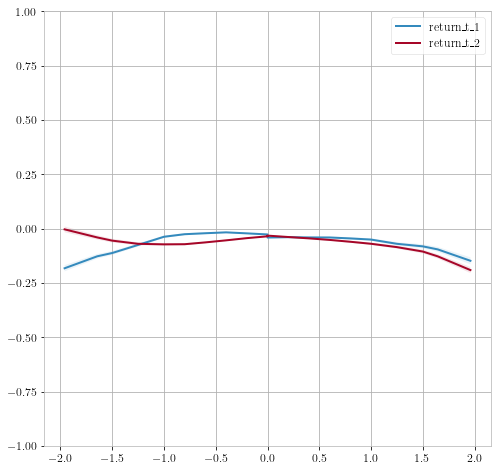

In [82]:
fig, ax = plt.subplots(figsize=(8,8))

for r_t in list(mean_r.keys())[:2]:
    mean = np.array(list(mean_r[r_t].values())) *100
    err  = np.array(list(std_err[r_t].values()))*100
    
    ax.plot(z_scores_all, mean, label=r_t)
    ax.fill_between(z_scores_all, mean+err, mean-err, alpha=.1) 


ax.set_ylim([-1,1])
ax.legend()
plt.show()

In [97]:
zvals_returns.head()

,Ticker,z_value,return_t_V,return_t_IV,return_t_III,return_t_II,return_t_I,return_t,return_t_1,return_t_2,return_t_3,return_t_4,return_t_5,return_t_6,return_t_7,return_t_8
Date,,,,,,,,,,,,,,,,
2002-06-24,TUP,-0.634287,0.000544,-0.003159,0.008415,0.002637,-0.004203,0.000075,-0.000779,0.012257,-0.002270,-0.018509,-0.002122,0.011387,0.020231,0.003777
2002-06-24,PGR,-0.608941,-0.007635,0.002577,0.011225,-0.000245,-0.004359,0.003398,0.004261,0.017140,-0.006788,-0.009035,-0.000093,-0.003206,0.009620,-0.001798
2002-06-24,RDC,0.114708,0.014523,0.000404,0.007893,0.009300,0.029689,0.015699,0.024991,0.014700,-0.003591,-0.007434,0.005948,0.011559,0.008987,0.006815
2002-06-24,CTB,-0.595646,-0.013183,-0.006875,0.012835,-0.001632,0.000080,-0.001382,-0.010273,0.024532,-0.006605,-0.022590,0.006711,0.013750,0.005426,-0.011465
2002-06-24,MCD,-0.022611,0.018654,0.000625,0.007451,0.000376,-0.010924,0.000986,-0.004916,-0.003854,-0.007262,-0.000397,0.000980,0.000585,0.008637,0.015548


In [98]:
z_score = 1.645

period_start = datetime(2002,1,1)
period_end   = datetime(2019,12,31)

strategy_df = zvals_returns.loc[zvals_returns.z_value <= -z_score]
strategy_df = strategy_df.loc[period_start:period_end]
strategy_df.shape

(101348, 16)

In [104]:
# Descriptive Statistics
x = 'return_t_1'

stats_df = pd.DataFrame(columns=[x])
stats_df.loc['mean in %', x]      = round(strategy_df[x].dropna().mean()*100,3)
stats_df.loc['mean p.a.in %', x]  = round(strategy_df[x].dropna().mean()*100*252,3)
stats_df.loc['sd in %', x]        = round(strategy_df[x].dropna().std()*100,3)
stats_df.loc['sd p.a. in %', x]   = round(strategy_df[x].dropna().std()*100*np.sqrt(252),3)
stats_df.loc['standard error', x] = round((strategy_df[x].dropna().std()/np.sqrt(strategy_df[x].dropna().shape[0]))*100,3)   # standard error of the mean
stats_df.loc['t_val', x]   = ttest_1samp(strategy_df[x].dropna(), 0)[0]
stats_df.loc['p_val', x]   = ttest_1samp(strategy_df[x].dropna(), 0)[1]
stats_df.loc['support', x] = strategy_df[x].dropna().shape[0]
stats_df

,return_t_1
mean in %,0.101
mean p.a.in %,25.564
sd in %,1.923
sd p.a. in %,30.533
standard error,0.006
t_val,16.784394
p_val,0.0
support,101273


In [105]:
df = strategy_df

start, end, intervall = 2002, 2020, 3
periodic_returns = {}
periodic_std_dev = {}
observations     = {}
periodic_std_err = {}

for i, year in enumerate(range(start, end, intervall)):
    returns_t = pd.DataFrame(data={}, columns=r_cols, index=['neg'])
    std_dev_t = pd.DataFrame(data={}, columns=r_cols, index=['neg'])
    
    df_y = df.loc[(year <= df.index.get_level_values('Date').year) & (df.index.get_level_values('Date').year < year+intervall), :]

    for return_t_n in r_cols:
        returns_t.loc['neg', return_t_n] = df_y[return_t_n].mean()
        std_dev_t.loc['neg', return_t_n] = df_y[return_t_n].std()
        
    periodic_returns[str(year)+'-'+str(year+intervall-1)] = returns_t*100
    periodic_std_dev[str(year)+'-'+str(year+intervall-1)] = std_dev_t*100
    observations[str(year)+'-'+str(year+intervall-1)]     = df_y.dropna().shape[0]
    periodic_std_err[str(year)+'-'+str(year+intervall-1)] = (std_dev_t/np.sqrt(df_y.dropna().shape[0]))*100

In [106]:
periodic_returns[list(periodic_returns.keys())[0]]

,return_t_V,return_t_IV,return_t_III,return_t_II,return_t_I,return_t,return_t_1,return_t_2,return_t_3,return_t_4,return_t_5,return_t_6,return_t_7,return_t_8
neg,0.050077,-0.03136,0.203698,0.552237,0.02433,0.318212,-0.034943,-0.171076,0.034527,0.06068,0.078254,0.080763,-0.060812,0.079376


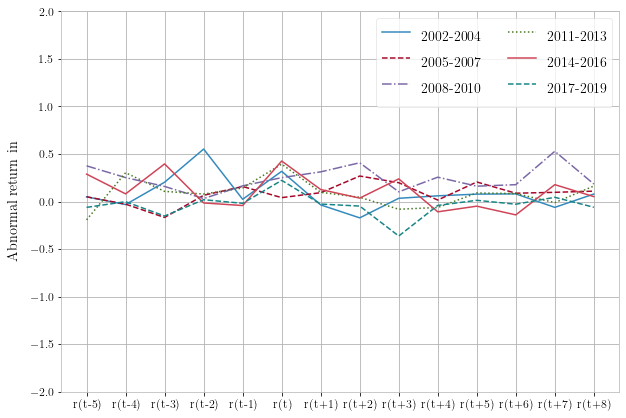

In [107]:
use_abnormal_returns = True
p = 'neg'

linestyles = {1:'-', 2:'--', 3:'-.', 4:':', 5:'-', 6:'--', 7:'-.', 8:':', 9:'-', 10:'--', 11:'-.'}
x_values   = ['r(t-5)', 'r(t-4)', 'r(t-3)', 'r(t-2)', 'r(t-1)', 'r(t)', 'r(t+1)', 'r(t+2)', 'r(t+3)', 'r(t+4)', 'r(t+5)', 'r(t+6)', 'r(t+7)', 'r(t+8)']

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
plt.subplots_adjust(hspace = 0.4)

for i, year in enumerate(range(start, end, intervall)):
    if year+intervall > end:
        break
    
    mean_return = periodic_returns[str(year)+'-'+str(year+intervall-1)].loc[p, 'return_t_V':'return_t_8']
    std_error   = periodic_std_err[str(year)+'-'+str(year+intervall-1)].loc[p, 'return_t_V':'return_t_8']
    above_line  = (mean_return.values+std_error.values).astype(np.float32)
    below_line  = (mean_return.values-std_error.values).astype(np.float32)
        
    axs.plot(x_values, mean_return, linewidth=1.5, label=str(year)+'-'+str(year+intervall-1), linestyle=linestyles[i+1])
    #axs.fill_between(x_values, above_line, below_line, alpha=.1) 
    
    #axs.set_title(str(year)+'-'+str(year+intervall))   
    axs.legend()  
    if use_abnormal_returns:
        axs.set_ylabel('Abnormal return in %', labelpad=10)
    else:
        axs.set_ylabel('Return in %', labelpad=10)
    #axs.set_xlabel(str(f"(Based on {observations[str(year)+'-'+str(year+intervall)]} observations)"), labelpad=10)
    plt.ylim(-2, 2)
    plt.legend(fontsize=14, ncol=2, handleheight=2.4, labelspacing=0.05)

#plt.savefig('C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/Bilder/event_study_z_values_barrier_0_95.pdf', bbox_inches='tight')
plt.show()

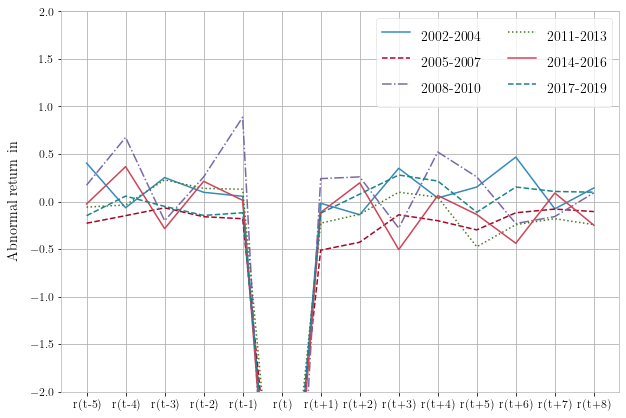

In [11]:
use_abnormal_returns = True
p = 'neg'

linestyles = {1:'-', 2:'--', 3:'-.', 4:':', 5:'-', 6:'--', 7:'-.', 8:':', 9:'-', 10:'--', 11:'-.'}
x_values   = ['r(t-5)', 'r(t-4)', 'r(t-3)', 'r(t-2)', 'r(t-1)', 'r(t)', 'r(t+1)', 'r(t+2)', 'r(t+3)', 'r(t+4)', 'r(t+5)', 'r(t+6)', 'r(t+7)', 'r(t+8)']

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
plt.subplots_adjust(hspace = 0.4)

for i, year in enumerate(range(start, end, intervall)):
    if year+intervall > end:
        break
    
    mean_return = periodic_returns[str(year)+'-'+str(year+intervall-1)].loc[p, 'return_t_V':'return_t_8']
    std_error   = periodic_std_err[str(year)+'-'+str(year+intervall-1)].loc[p, 'return_t_V':'return_t_8']
    above_line  = (mean_return.values+std_error.values).astype(np.float32)
    below_line  = (mean_return.values-std_error.values).astype(np.float32)
        
    axs.plot(x_values, mean_return, linewidth=1.5, label=str(year)+'-'+str(year+intervall-1), linestyle=linestyles[i+1])
    #axs.fill_between(x_values, above_line, below_line, alpha=.1) 
    
    #axs.set_title(str(year)+'-'+str(year+intervall))   
    axs.legend()  
    if use_abnormal_returns:
        axs.set_ylabel('Abnormal return in %', labelpad=10)
    else:
        axs.set_ylabel('Return in %', labelpad=10)
    #axs.set_xlabel(str(f"(Based on {observations[str(year)+'-'+str(year+intervall)]} observations)"), labelpad=10)
    plt.ylim(-2, 2)
    plt.legend(fontsize=14, ncol=2, handleheight=2.4, labelspacing=0.05)

#plt.savefig('C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/Bilder/event_study_z_values_barrier_0_95.pdf', bbox_inches='tight')
plt.show()

In [ ]:
x_values = ['r(t+1)', 'r(t+2)', 'r(t+3)', 'r(t+4)', 'r(t+5)', 'r(t+6)', 'r(t+7)', 'r(t+8)']

plots = int((end-start)/intervall)
if plots == 1:
    nrow, ncol = 1,1
else:
    nrow, ncol = math.ceil(plots/2), 2 
    
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*7,nrow*7))
plt.subplots_adjust(hspace = 0.4)
k = -1
p = 'neg'

for i, year in enumerate(range(start, end, intervall)):
    if year+intervall > end:
        break
    if nrow > 1:
        if (i+1)%2 == 0:
            l = 1
        else:
            l =  0
            k += 1
        axs[k,l].plot(x_values, periodic_returns[str(year)+'-'+str(year+intervall-1)].loc[p, 'return_t_1':'return_t_8'], linewidth=1.5, linestyle='solid')
        axs[k,l].set_title(str(year)+'-'+str(year+intervall))
        #if k == 0 and l == 0:
            #axs[k,l].legend()  
        axs[k,l].set_ylim([-2.0, 2.0])
        #axs[k,l].set_xlabel(str(f"Based on {observations[f][str(year)+'-'+str(year+intervall)]} observations"), labelpad=10)
    else:
        axs.plot(x_values, periodic_returns[str(year)+'-'+str(year+intervall-1)].loc[p, 'return_t_1':'return_t_8'], linewidth=1.5, linestyle='solid')
        axs.set_title(str(year)+'-'+str(year+intervall-1))   
        #axs.legend()  
        axs.set_xlabel(str(f"(Based on {observations[str(year)+'-'+str(year+intervall-1)]} observations)"), labelpad=10)
        #plt.ylim(-2.0, 2.0)

#plt.savefig('C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/Bilder/event_study_2002_2020_'+list(freshness.keys())[0]+'_barrier_0_95.pdf', bbox_inches='tight')
plt.show()

##  
### Short-Term Momentum Effect

We investigate the effects of specific series of corporate financial news events and their effects on associated asset returns.
Financial news of company XY, that are published during market closing hours (4pm to 9:30am), tend to be followed by positive (negative) average next-day returns if the news are classified as positive (negative).     
  
We observe that this effect is amplified if the market shows a strong reaction to those news events. A negative news article that is occompanied with a sharp price drop on the same day receives more investor attention than a negative sounding news article without a significant price drop. The data shows that the release of another negative news article later in the evening during market closing hours lowers the likelihood of a possible reversal on the following trading day in favor of a further drop in prices due to the growing fear of a continuing sell-off. 

**Null Hypothesis H0**    
Asset returns show no predictability on day t=t1 based on information contained in financial news that is available on day t=t1. Thus, the mean return on day t=t2 = 0.

**Hypothesis H1**  
Negative company news released on day t=1 that go hand-in-hand with significantely neagative returns on day t=1 tend to be followed by negative returns on day t=2.

**Hypothesis H2**  
A 2-day series of negative company news released on day t=t0 and t=t1, that go hand-in-hand with negative daily returns on day t=t0 and t=t1 tend to be followed by further negative returns on day t=t2 (and t=t3).

**Hypothesis H3**  
A 3-day series of negative news events from day t=t0 to t=t2 that goes hand-in-hand with declining prices shows an increased likelihood of a reversal on day t=t3.  

In [6]:
class construct_df():
    def __init__(self, 
                 trade_time = 'MOO', 
                 use_abnormal_returns  = False, 
                 idiosync_z_scores = False, 
                 z_val_interval_moc = 'z_values_moc_127d_rw',
                 z_val_interval_moo = ''):
        """
        trade_time:
        MOO ... market order open
        MOC ... market order close
        """
        col0 = ['Timestamp_ET', 'Ticker', 'Date', 'prediction_value']
        col1 = ['Timestamp_ET', 'Ticker', 'Date', 'prediction_value', 'z_value_t']+ r_cols

        idiosync = '_idiosync' if idiosync_z_scores else ''
        abn = '_abn' if use_abnormal_returns else '' 
        
        file1 = f'train_valid_data_pred_and{abn}_returns_mc_to_mc_6_5h_z_val{idiosync}_fresh_2002-2021.csv'
        file2 = f'train_valid_data_pred_and{abn}_returns_mo_to_mc_17_5h_z_val{idiosync}{z_val_interval_moo}_fresh_2002-2021.csv'
        file3 = z_val_interval_moc+idiosync+'.csv'
        print(f'Load {file1}')
        print(f'Load {file2}')
        print(f'Load {file3}')
        df_mo_to_mc = self.load_data(extended_model_path+file1)       # market open to maket close
        df_mc_to_mo = self.load_data(extended_model_path+file2)       # market close to maket open         
                
        # Load z-values (file reference: Stock Return Calculation.ipynb)
        z_values_moc = pd.read_csv(data_path+file3, encoding='utf-8')   
        z_values_moc.Date = pd.to_datetime(z_values_moc.Date)
        z_values_moc = z_values_moc.set_index('Date')
        self.z_values_moc_t_I = z_values_moc.shift(1)

        if trade_time == 'MOO':    
            df_mo_to_mc = df_mo_to_mc[col0]
            df_mc_to_mo = df_mc_to_mo[col1]

            # Add z-value of market close on day t-1
            df_mc_to_mo.insert(3, 'z_value_t_I', np.nan)
            df_mc_to_mo['z_value_t_I'] = df_mc_to_mo.apply(self.get_z_val, axis=1)

        elif trade_time == 'MOC':
            df_mo_to_mc = df_mo_to_mc[col1]
            df_mc_to_mo = df_mc_to_mo[col0]   

        df_mo_to_mc['period'] = 'mo_to_mc'
        df_mc_to_mo['period'] = 'mc_to_mo'

        self.df = pd.concat([df_mo_to_mc, df_mc_to_mo], join='outer', axis=0)
        self.df = self.df.sort_values(by='Timestamp_ET').reset_index(drop=True)
        self.df.Date = pd.to_datetime(self.df.Date)
        self.df.Timestamp_ET = pd.to_datetime(self.df.Timestamp_ET)
        self.df = self.df.set_index('Timestamp_ET')


    def load_data(self, file):
        df = pd.read_csv(file, encoding='utf-8-sig')
        df.Date = pd.to_datetime(df.Date)
        df = df.rename(columns={'Prediction value': 'prediction_value'})
        return df
    
    
    def get_z_val(self, x):
        return self.z_values_moc_t_I.loc[x.Date, x.Ticker] 
    
    
    def sel_period(self, start_date, end_date):
        return self.df.loc[start_date:end_date]
    


    
    
    
# moh ... market opening hours  -> 9:30am(t) - 4pm(t)
# mch ... market closing hours  ->  4pm(t-1) - 9:30am(t)

def get_df_slice(df, dates, i, cols):
    return df.loc[((datetime.combine(dates[i-1], time(16,0)) <= df.index) & (df.index < datetime.combine(dates[i], time(16,0)))), cols]


def merge_predictions(df, trade_time):
    dates = pd.DatetimeIndex(df.Date.unique())

    for i, date in enumerate(dates[1:-2]):

        df_t_II = get_df_slice(df, dates, i,   cols=['Ticker', 'period', 'prediction_value'])
        df_t_I  = get_df_slice(df, dates, i+1, cols=['Ticker', 'period', 'prediction_value'] )
        df_t    = get_df_slice(df, dates, i+2, cols=['Ticker', 'period', 'z_value_t_I', 'z_value_t'] + r_cols + ['prediction_value'])


        if trade_time == 'MOO':
            df_vals_t = df_t.loc[df_t.period=='mc_to_mo'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_mch'})

        elif trade_time == 'MOC':
            df_vals_t = pd.merge(left  = df_t.loc[df_t.period=='mo_to_mc'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_moh'}),
                                 right = df_t.loc[df_t.period=='mc_to_mo', ['Ticker', 'prediction_value']].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_mch'}), 
                                 left_index  = True,
                                 right_index = True, 
                                 how = 'outer')

        df_vals_t_I  = pd.merge(left  = df_t_I.loc[df_t_I.period=='mo_to_mc'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_I_moh'}),
                                right = df_t_I.loc[df_t_I.period=='mc_to_mo'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_I_mch'}), 
                                left_index  = True,
                                right_index = True, 
                                how = 'outer')

        df_vals_t_tI = pd.merge(left=df_vals_t, right=df_vals_t_I, left_index=True, right_index=True, how='left')

        df_vals_t_II = pd.merge(left  = df_t_II.loc[df_t_II.period=='mo_to_mc'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_II_moh'}),
                                right = df_t_II.loc[df_t_II.period=='mc_to_mo'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_II_mch'}), 
                                left_index  = True,
                                right_index = True, 
                                how = 'outer')

        df_vals = pd.merge(left=df_vals_t_tI, right=df_vals_t_II, left_index=True, right_index=True, how='left')

        if i == 0:
            pred_return_df = df_vals.copy()
        else:
            pred_return_df = pd.concat([pred_return_df, df_vals], axis=0)
        
    return pred_return_df

In [8]:
trade_time = 'MOO'
event_df = construct_df(trade_time, use_abnormal_returns=True, idiosync_z_scores=True) 

Load train_valid_data_pred_and_abn_returns_mc_to_mc_6_5h_z_val_idiosync_fresh_2002-2021.csv
Load train_valid_data_pred_and_abn_returns_mo_to_mc_17_5h_z_val_idiosync_fresh_2002-2021.csv
Load z_values_moc_127d_rw_idiosync.csv


In [9]:
start_date = datetime(2002,1,1)
end_date   = datetime(2019,12,31)

df = event_df.sel_period(start_date, end_date)

print(df.shape)
df.head(3)

(236249, 20)


,Ticker,Date,prediction_value,period,z_value_t_I,z_value_t,return_t_V,return_t_IV,return_t_III,return_t_II,return_t_I,return_t,return_t_1,return_t_2,return_t_3,return_t_4,return_t_5,return_t_6,return_t_7,return_t_8
Timestamp_ET,,,,,,,,,,,,,,,,,,,,
2002-01-07 16:28:06.983,DIS,2002-01-07,0.008352,mc_to_mo,NaN,NaN,NaN,0.020357,-0.008842,0.012795,-0.005437,-0.033163,-0.064432,0.035197,0.012096,-0.000138,0.045765,-0.025760,0.037316,NaN
2002-01-07 16:40:01.416,XRX,2002-01-07,0.019154,mc_to_mo,NaN,NaN,NaN,-0.011870,-0.005273,0.008129,-0.000622,0.033708,-0.026919,0.041696,-0.005990,0.009757,0.081039,0.017904,0.013545,-0.049118
2002-01-07 16:49:57.742,JWN,2002-01-07,0.015895,mc_to_mo,NaN,NaN,NaN,-0.015618,0.010514,0.022550,-0.045395,-0.021867,-0.066170,0.052744,-0.012567,-0.000007,0.049642,0.017003,0.028830,-0.014969


In [10]:
pred_return_df = merge_predictions(df, trade_time)

print(pred_return_df.shape)
pred_return_df.head()

(114554, 21)


,z_value_t_I,z_value_t,return_t_V,return_t_IV,return_t_III,return_t_II,return_t_I,return_t,return_t_1,return_t_2,return_t_3,return_t_4,return_t_5,return_t_6,return_t_7,return_t_8,prediction_value_t_mch,prediction_value_t_I_moh,prediction_value_t_I_mch,prediction_value_t_II_moh,prediction_value_t_II_mch
Ticker,,,,,,,,,,,,,,,,,,,,,
AAPL,NaN,NaN,0.046047,0.007411,0.020481,-0.068768,-0.030682,-0.082123,0.058640,0.004330,0.022383,0.098047,0.006581,0.057202,-0.067381,NaN,0.004717,0.001676,0.003186,NaN,NaN
AV,NaN,NaN,0.020504,-0.011577,0.031642,-0.053163,0.022700,-0.147874,0.057997,-0.030561,-0.020739,0.087506,0.031165,0.025215,-0.075516,NaN,0.091278,NaN,-0.632140,NaN,NaN
BA,NaN,NaN,-0.016351,0.001000,0.020401,NaN,-0.038554,-0.026714,0.020028,-0.019622,-0.004169,0.056311,0.001017,0.009811,-0.013176,NaN,0.004932,-0.009619,NaN,NaN,NaN
BBY,NaN,NaN,-0.035475,-0.000136,-0.001264,-0.050760,-0.011120,-0.053422,0.052995,0.006389,0.015509,0.101548,0.031914,0.032379,-0.067538,NaN,0.968481,NaN,NaN,NaN,NaN
CSCO,NaN,NaN,0.027901,0.037730,-0.009226,-0.069340,-0.016918,-0.063517,0.090017,0.011060,0.007203,0.107378,0.026994,0.059442,-0.103305,NaN,0.003163,NaN,NaN,NaN,NaN


In [11]:
return_val      = 'return_t' # We consider the return from market open to market open on day t+1
z_val_barrier   = 1.645
z_val_barrier_I = 0.4
barrier         = 0.95        # predicted_sentiment >= barrier -> positive (long) | predicted_sentiment <= barrier -> negative (short)

if trade_time == 'MOO':
    recent_period = 'prediction_value_t_mch'
elif trade_time == 'MOC':    
    recent_period = 'prediction_value_t_moh'
    
plot_df = pd.DataFrame()

#columns=['1d_neg_z_return', '1d_neg_z_I_pos_return', '1d_neg_z_I_neg_return', '2d_neg_z_return', '1d_neg_return', '2d_neg_return', '1d_pos_return', '2d_pos_return'])

# Positive/Negative news on day t ------------------------------------------------------------------------------------------
#plot_df['1d_neg_return'] = pred_return_df.loc[(pred_return_df[recent_period] <= -barrier), return_val].reset_index(drop=True)
#plot_df['1d_pos_return'] = pred_return_df.loc[(pred_return_df[recent_period] >=  barrier), return_val].reset_index(drop=True)

F
# Negative news on day t and significantely negative z-value on day t -------------------------------------------------------
#plot_df['1d_neg_z_return'] = pred_return_df.loc[(pred_return_df[recent_period]   <= -barrier) &
#                                                (pred_return_df.z_value_t        <= -z_val_barrier) &
#                                                (abs(pred_return_df.z_value_t_I) <= z_val_barrier_I), return_val].reset_index(drop=True)

# Positive news on day t and significantely positive z-value on day t -------------------------------------------------------
#plot_df['1d_pos_z_return'] = pred_return_df.loc[(pred_return_df[recent_period]   >= barrier) &
#                                                (pred_return_df.z_value_t        >= z_val_barrier) &
#                                                (abs(pred_return_df.z_value_t_I) <= z_val_barrier_I), return_val].reset_index(drop=True)


# Negative news on day t and significantely negative z-value on day t -------------------------------------------------------
#plot_df['1d_neg_z_return'] = pred_return_df.loc[(pred_return_df[recent_period] <= -barrier) &
#                                                (pred_return_df.z_value_t      <= -z_val_barrier), return_val].reset_index(drop=True)

# Positive news on day t and significantely positive z-value on day t -------------------------------------------------------
#plot_df['1d_pos_z_return'] = pred_return_df.loc[(pred_return_df[recent_period] >= barrier) &
#                                                (pred_return_df.z_value_t      >= z_val_barrier), return_val].reset_index(drop=True)


# Negative news on day t and significantely negative z-value on day t-1 at market close -------------------------------------
#plot_df['1d_neg_z_I_neg_return'] = pred_return_df.loc[(pred_return_df[recent_period] <= -barrier)      &
#                                                      (pred_return_df.z_value_t_I    <= -z_val_barrier), return_val].reset_index(drop=True)


# Positive news on day t and significantely positive z-value on day t-1 at market close -------------------------------------
#plot_df['1d_pos_z_I_pos_return'] = pred_return_df.loc[(pred_return_df[recent_period] >= barrier) &
#                                                      (pred_return_df.z_value_t_I    >= z_val_barrier), return_val].reset_index(drop=True)

                                
# Positive news on day t and significantely negative z-value on day t -------------------------------------
#plot_df['1d_pos_z_neg_return'] = pred_return_df.loc[(pred_return_df[recent_period] >= barrier) &
#                                                    (pred_return_df.z_value_t      <= -z_val_barrier), return_val].reset_index(drop=True)
  

# Negative news on day t and significantely positive z-value on day t -------------------------------------
#plot_df['1d_neg_z_pos_return'] = pred_return_df.loc[(pred_return_df[recent_period] <= -barrier)      &
#                                                    (pred_return_df.z_value_t      >= z_val_barrier), return_val].reset_index(drop=True)


# Positive news on day t and significantely negative z-value on day t-1 at market close -------------------------------------
#plot_df['1d_pos_z_I_neg_return'] = pred_return_df.loc[(pred_return_df[recent_period] >= barrier) &
#                                                      (pred_return_df.z_value_t_I    <= -z_val_barrier), return_val].reset_index(drop=True)
  

# Negative news on day t and significantely positive z-value on day t-1 at market close -------------------------------------
#plot_df['1d_neg_z_I_pos_return'] = pred_return_df.loc[(pred_return_df[recent_period] <= -barrier)      &
#                                                      (pred_return_df.z_value_t_I    >= z_val_barrier), return_val].reset_index(drop=True)



# Positive/Negative news on day t and on day t-1 ---------------------------------------------------------------------------
#plot_df['2d_neg_return'] = pred_return_df.loc[(pred_return_df['prediction_value_t_I_moh'] <= -barrier) &
#                                              (pred_return_df[recent_period] <= -barrier), return_val].reset_index(drop=True)

#plot_df['2d_pos_return'] = pred_return_df.loc[(pred_return_df['prediction_value_t_I_moh'] >= barrier)  & 
#                                              (pred_return_df[recent_period] >= barrier), return_val].reset_index(drop=True)


# Negative news on day t and on day t-1 and significantely negative z-value on day t ----------------------------------------
#plot_df['2d_neg_z_return'] = pred_return_df.loc[(pred_return_df[['prediction_value_t_I_moh', 'prediction_value_t_I_mch']].mean(axis=1) <= -barrier) & 
#                                                (pred_return_df[recent_period] <= -barrier) &
#                                                (pred_return_df.z_value_t      <= -z_val_barrier), return_val].reset_index(drop=True)


#plot_df['tI_mch_neg_z_return'] = pred_return_df.loc[(pred_return_df.prediction_value_t_I_mch <= -barrier) & 
#                                                    (pred_return_df.prediction_value_t_I_moh <= -barrier) & 
#                                                    (pred_return_df[recent_period] <= -barrier) &
#                                                    (pred_return_df.z_value_t      <= -z_val_barrier), return_val].reset_index(drop=True)


#plot_df['tI_moh_pos_return'] = pred_return_df.loc[(pred_return_df.prediction_value_t_I_moh >= barrier) & 
#                                                    (pred_return_df[recent_period] >= barrier), return_val].reset_index(drop=True)


#plot_df['tI_moh_neg_z_return'] = pred_return_df.loc[(pred_return_df.prediction_value_t_I_moh <= -barrier) & 
#                                                    (pred_return_df[recent_period] <= -barrier) &
#                                                    (pred_return_df.z_value_t      <= -z_val_barrier), return_val].reset_index(drop=True)


#plot_df['tI_moh_neg_return'] = pred_return_df.loc[(pred_return_df.prediction_value_t_I_moh <= -barrier) & 
#                                                  (pred_return_df[recent_period] <= -barrier), return_val].reset_index(drop=True)


# Negative news on day t, on day t-1 and on day t-2 and significantely negative z-value on day t -----------------------------
#plot_df['3d_neg_z_return'] = pred_return_df.loc[(pred_return_df[['prediction_value_t_II_moh', 'prediction_value_t_II_mch']].mean(axis=1) <= -barrier) & 
#                                                (pred_return_df[['prediction_value_t_I_moh', 'prediction_value_t_I_mch']].mean(axis=1)   <= -barrier) & 
#                                                (pred_return_df[recent_period] <= -barrier) &
#                                                (pred_return_df.z_value_t      <= -z_val_barrier), return_val].reset_index(drop=True)


# Positive/Negative news on day t, on day t-1 and on day t-2 ----------------------------------------------------------------
#plot_df['3d_pos_return'] = pred_return_df.loc[(pred_return_df[['prediction_value_t_II_moh', 'prediction_value_t_II_mch']].mean(axis=1) >= barrier)  & 
#                                              (pred_return_df[['prediction_value_t_I_moh', 'prediction_value_t_I_mch']].mean(axis=1)   >= barrier)  &
#                                              (pred_return_df[recent_period] >= barrier), return_val].reset_index(drop=True)

#plot_df['3d_neg_return'] = pred_return_df.loc[(pred_return_df[['prediction_value_t_II_moh', 'prediction_value_t_II_mch']].mean(axis=1) <= -barrier) & 
#                                              (pred_return_df[['prediction_value_t_I_moh', 'prediction_value_t_I_mch']].mean(axis=1)   <= -barrier) & 
#                                              (pred_return_df[recent_period] <= -barrier), return_val].reset_index(drop=True)


In [12]:
stats_df = pd.DataFrame(columns=plot_df.columns)
for x in stats_df:
    stats_df.loc['mean in %', x]      = round(plot_df[x].dropna().mean()*100,3)
    stats_df.loc['mean p.a.in %', x]  = round(plot_df[x].dropna().mean()*100*252,3)
    stats_df.loc['sd in %', x]        = round(plot_df[x].dropna().std()*100,3)
    stats_df.loc['sd p.a. in %', x]   = round(plot_df[x].dropna().std()*100*np.sqrt(252),3)
    stats_df.loc['standard error', x] = round((plot_df[x].dropna().std()/np.sqrt(plot_df[x].dropna().shape[0]))*100,3)   # standard error of the mean
    stats_df.loc['t_val', x]   = ttest_1samp(plot_df[x].dropna(), 0)[0]
    stats_df.loc['p_val', x]   = ttest_1samp(plot_df[x].dropna(), 0)[1]
    stats_df.loc['support', x] = plot_df[x].dropna().shape[0]
    
stats_df

,1d_neg_z_return,1d_pos_z_return
mean in %,-0.319,0.275
mean p.a.in %,-80.438,69.235
sd in %,4.498,3.371
sd p.a. in %,71.404,53.507
standard error,0.111,0.083
t_val,-2.885203,3.302989
p_val,0.003962,0.000977
support,1653,1642


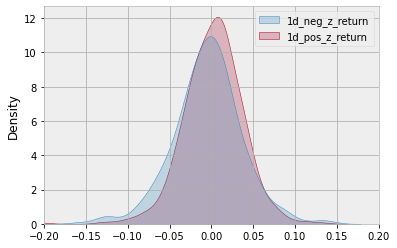

In [390]:
fix, ax = plt.subplots(figsize=(6,4))
sns.kdeplot(data=plot_df[['1d_neg_z_return', '1d_pos_z_return']], common_norm=False, fill=True, cumulative=False)
plt.xlim(-0.2, 0.2)
plt.show()

## 
### Returns and Sentiment measured from close to open

In [8]:
def load_data(file):
    df = pd.read_csv(file, encoding='utf-8-sig')
    df.Date = pd.to_datetime(df.Date)
    df = df.rename(columns={'Prediction value': 'prediction_value'})
    return df



def unconditional(z_score, return_val):
    # Negative z-value on day t ---------------------------------
    Case_1 = zvals_returns.loc[zvals_returns.z_value <= -z_score, return_val].dropna().reset_index(drop=True)

    # Positive z-value on day t ---------------------------------
    Case_2 = zvals_returns.loc[zvals_returns.z_value >=  z_score, return_val].dropna().reset_index(drop=True)

    strategy_df = pd.concat([Case_1, Case_2], axis=1)
    strategy_df.columns = [f'Case_{i}' for i in range(1,3)]
    return strategy_df

        
def conditional(z_score, barrier, return_val): 
    # Positive news on day t and significantely positive z-value on day t-1 at market close 
    Case_1 = pred_return_df.loc[(pred_return_df.prediction_value >= barrier) &
                                (pred_return_df.z_value_t_I      >= z_score), 
                                 return_val].reset_index(drop=True)
    
    # Negative news on day t and significantely negative z-value on day t-1 at market close 
    Case_2 = pred_return_df.loc[(pred_return_df.prediction_value <= -barrier) &
                                (pred_return_df.z_value_t_I      <= -z_score), 
                                 return_val].reset_index(drop=True)

    # Positive news on day t and significantely negative z-value on day t-1 at market close
    Case_3 = pred_return_df.loc[(pred_return_df.prediction_value >=  barrier) &
                                (pred_return_df.z_value_t_I      <= -z_score), 
                                 return_val].reset_index(drop=True)
    
    # Negative news on day t and significantely positve z-value on day t-1 at market close  
    Case_4 = pred_return_df.loc[(pred_return_df.prediction_value <= -barrier) &
                                (pred_return_df.z_value_t_I      >=  z_score), 
                                 return_val].reset_index(drop=True)
   
    # Positive news on day t ---------------
    Case_5 = pred_return_df.loc[(pred_return_df.prediction_value >= barrier), 
                                 return_val].reset_index(drop=True)
    
    
    # Negative news on day t ---------------
    Case_6 = pred_return_df.loc[(pred_return_df.prediction_value <= -barrier), 
                                 return_val].reset_index(drop=True)
    
    
    strategy_df = pd.concat([Case_1, Case_2, Case_3, Case_4, Case_5, Case_6], axis=1)
    strategy_df.columns = [f'Case_{i}' for i in range(1,7)]
    return strategy_df

In [9]:
# -> returns market close to open
# -> z-values market close to close
use_abnormal_returns  = True
idiosync_z_scores     = True
abn = '_abn' if use_abnormal_returns else '' 
idiosync = '_idiosync' if idiosync_z_scores else ''

pred_return_df = load_data(extended_model_path+f'train_valid_data_pred_and{abn}_returns_mc_to_mo17_5h_z_val{idiosync}_fresh_2002-2021.csv')

In [10]:
# Load return data with z_value signals
zvals_returns = pd.read_csv(extended_model_path+f'z_values_127d_mo_to_mc{idiosync}{abn}_returns_mc_to_mo_2002-2021.csv', encoding='utf-8-sig')   
zvals_returns = zvals_returns.rename(columns = {'Unnamed: 0':'Ticker'})
zvals_returns.Date = pd.to_datetime(zvals_returns.Date)
zvals_returns = zvals_returns.set_index(['Date'])
zvals_returns.shape

(2137258, 16)

In [12]:
conditional(z_score=1.645, barrier=0.90, return_val='return_t').mean()*100

Case_1    1.027200
Case_2   -1.295368
Case_3    1.204624
Case_4   -0.769216
Case_5    1.384714
Case_6   -1.513573
dtype: float64

In [13]:
z_scores = [0.0001, 0.2, 0.4, 0.6, 0.8, 1.0, 1.25, 1.5, 1.645, 1.96]
iterables = [['mean', 'sd', 'std_error', 't_value'], ['Case_1_2', 'Case_3_4']]
index     = pd.MultiIndex.from_product(iterables, names=["Variable", "Case"])

table = {} 
settings = ['conditional', 'unconditional']

data_conditional = {}

for setting in settings:
    table[setting] = pd.DataFrame(index=index, columns=[-z_scores[i] for i in range(len(z_scores)-1,-1,-1)]+z_scores)
    for z_score in z_scores:       
        if setting == 'conditional':
            strategy_df = conditional(z_score=z_score, barrier=0.95, return_val='return_t')
            data_conditional[z_score] = strategy_df
            
        if setting == 'unconditional':
            strategy_df = unconditional(z_score=z_score, return_val='return_t_1')
            
        table[setting].loc[('mean', 'Case_1_2'), -z_score] = strategy_df['Case_1'].dropna().mean()
        table[setting].loc[('mean', 'Case_1_2'),  z_score] = strategy_df['Case_2'].dropna().mean()                 
        table[setting].loc[('sd',   'Case_1_2'), -z_score] = strategy_df['Case_1'].dropna().std()
        table[setting].loc[('sd',   'Case_1_2'),  z_score] = strategy_df['Case_2'].dropna().std()                
        table[setting].loc[('std_error', 'Case_1_2'), -z_score] = strategy_df['Case_1'].dropna().std()/np.sqrt(strategy_df['Case_1'].dropna().shape[0])
        table[setting].loc[('std_error', 'Case_1_2'),  z_score] = strategy_df['Case_2'].dropna().std()/np.sqrt(strategy_df['Case_2'].dropna().shape[0])               
        table[setting].loc[('t_value',   'Case_1_2'), -z_score] = ttest_1samp(strategy_df['Case_1'].dropna(), 0)[0]
        table[setting].loc[('t_value',   'Case_1_2'),  z_score] = ttest_1samp(strategy_df['Case_2'].dropna(), 0)[0] 
        
        if setting == 'conditional':
            table[setting].loc[('mean', 'Case_3_4'), -z_score] = strategy_df['Case_3'].dropna().mean()
            table[setting].loc[('mean', 'Case_3_4'),  z_score] = strategy_df['Case_4'].dropna().mean()  
            table[setting].loc[('sd',   'Case_3_4'), -z_score] = strategy_df['Case_3'].dropna().std()
            table[setting].loc[('sd',   'Case_3_4'),  z_score] = strategy_df['Case_4'].dropna().std()        
            table[setting].loc[('std_error', 'Case_3_4'), -z_score] = strategy_df['Case_3'].dropna().std()/np.sqrt(strategy_df['Case_3'].dropna().shape[0])
            table[setting].loc[('std_error', 'Case_3_4'),  z_score] = strategy_df['Case_4'].dropna().std()/np.sqrt(strategy_df['Case_4'].dropna().shape[0])        
            table[setting].loc[('t_value',   'Case_3_4'), -z_score] = ttest_1samp(strategy_df['Case_3'].dropna(), 0)[0]
            table[setting].loc[('t_value',   'Case_3_4'),  z_score] = ttest_1samp(strategy_df['Case_4'].dropna(), 0)[0]

In [14]:
table['conditional']

-1.9600    -1.6450    -1.5000    -1.2500   -1.0000  \
Variable  Case                                                            
mean      Case_1_2   0.00907   0.010728   0.010784   0.010786  0.011946   
          Case_3_4  0.009986   0.013264   0.013407   0.013984  0.014279   
sd        Case_1_2  0.041482   0.046278   0.046679   0.046595  0.047409   
          Case_3_4   0.06195   0.060862   0.059743   0.056427  0.053571   
std_error Case_1_2  0.000962   0.000945   0.000888   0.000786  0.000697   
          Case_3_4   0.00209   0.001721   0.001535   0.001196  0.000959   
t_value   Case_1_2  9.427687  11.351412  12.139448  13.723496  17.14188   
          Case_3_4  4.778911   7.705436   8.734494  11.690096  14.89268   

                      -0.8000    -0.6000    -0.4000    -0.2000    -0.0001  \
Variable  Case                                                              
mean      Case_1_2   0.012752   0.012809   0.013409    0.01355    0.01354   
          Case_3_4   0.014887   0.015535   0.015797   0.015759    0.01586   
sd        Case_1_2   0.047124   0.047719   0.048272   0.049108    0.04891   
          Case_3_4   0.052378   0.051931   0.050328   0.049199   0.049478   
std_error Case_1_2   0.000615   0.000558   0.000505   0.000463   0.000422   
          Case_3_4   0.000812   0.000696   0.000589    0.00051    0.00046   
t_value   Case_1_2  20.724428  22.953858  26.546386  29.240886  32.115077   
          Case_3_4  18.324507  22.307527  26.805966  30.912747  34.514798   

                       0.0001     0.2000     0.4000     0.6000     0.8000  \
Variable  Case                                                              
mean      Case_1_2  -0.015978  -0.015669  -0.015474  -0.015123  -0.015209   
          Case_3_4  -0.018584  -0.018491  -0.018084  -0.016795  -0.014571   
sd        Case_1_2   0.059533   0.060326   0.060784   0.061211    0.06292   
          Case_3_4   0.063611   0.064296   0.065099   0.066114   0.064731   
std_error Case_1_2   0.000576   0.000637   0.000707   0.000795   0.000912   
          Case_3_4    0.00067   0.000744   0.000841   0.000966   0.001071   
t_value   Case_1_2 -27.744658 -24.585606 -21.874721 -19.027973 -16.679121   
          Case_3_4 -27.741195 -24.854403  -21.49054 -17.391098 -13.610774   

                       1.0000     1.2500     1.5000     1.6450    1.9600  
Variable  Case                                                            
mean      Case_1_2  -0.014919  -0.014839   -0.01536  -0.015376 -0.013764  
          Case_3_4  -0.013699  -0.012089  -0.011576  -0.009589 -0.006491  
sd        Case_1_2   0.063606   0.065233   0.065782   0.066248   0.06433  
          Case_3_4   0.066973   0.065998   0.068313   0.069072  0.071978  
std_error Case_1_2   0.001024    0.00119   0.001343   0.001444  0.001576  
          Case_3_4   0.001268   0.001464   0.001764   0.001935  0.002429  
t_value   Case_1_2 -14.563155 -12.469819 -11.433865 -10.651636 -8.735746  
          Case_3_4 -10.802469  -8.256995  -6.562935  -4.955321 -2.672161

In [10]:
def plot_results(table, cases=['Case_1_2', 'Case_3_4'], idiosyncratic=False, show_standard_error=True):       
    axes  = {}
    fig, (axes[0], axes[1]) = plt.subplots(1,2,figsize=(24,8))
    
    for i, case in enumerate(cases):
        if case == None:
            continue
        if idiosyncratic:
            title = f'Idiosyncratic mean returns in % ({case})'
        else: 
            title = f'Mean returns in % ({case})'

        mean_0       = table['unconditional'].loc[('mean', 'Case_1_2')]*100
        mean_1       = table['conditional'].loc[('mean', case)]*100
        std_error_0  = table['unconditional'].loc[('std_error', 'Case_1_2')]*100
        std_error_1  = table['conditional'].loc[('std_error', case)]*100

        above_line_0 = (mean_0.values+std_error_0.values).astype(np.float32)
        below_line_0 = (mean_0.values-std_error_0.values).astype(np.float32)
        above_line_1 = (mean_1.values+std_error_1.values).astype(np.float32)
        below_line_1 = (mean_1.values-std_error_1.values).astype(np.float32)
        
        axes[i].plot(mean_0, label='Unconditional')
        axes[i].plot(mean_1, label='Conditional')
        
        if show_standard_error:
            axes[i].fill_between(mean_1.index, above_line_1, below_line_1, color='b', alpha=.1) 

        axes[i].set_title(title)
        axes[i].set_xlabel('z-score')
        axes[i].set_ylabel('avg. daily return in %')
        axes[i].set_ylim([-2, 2])
        axes[i].legend()
    plt.show()

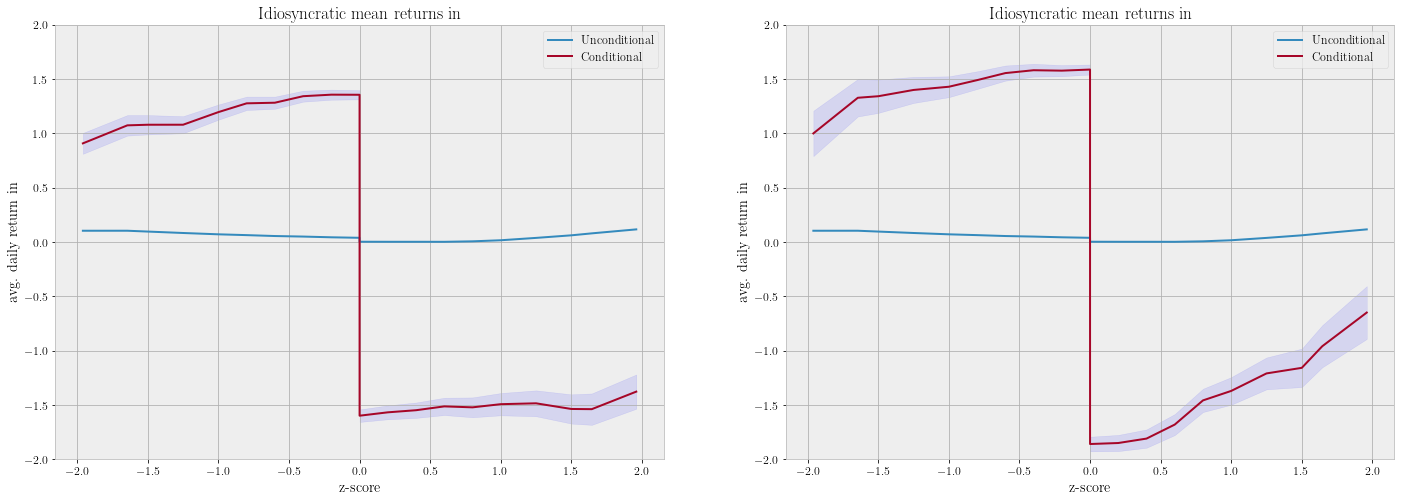

In [11]:
# With abnormal returns
plot_results(table, idiosyncratic=True, show_standard_error=True)

In [12]:
print(data_conditional.keys())
data_conditional[1.645].head()

dict_keys([0.0001, 0.2, 0.4, 0.6, 0.8, 1.0, 1.25, 1.5, 1.645, 1.96])


,Case_1,Case_2,Case_3,Case_4,Case_5,Case_6
0,0.119351,-0.065612,0.038388,0.035603,0.078009,0.005656
1,-0.008548,-0.131917,0.011141,0.012787,0.036007,-0.039411
2,-0.008548,-0.027277,0.001980,0.010536,0.119351,-0.065612
3,0.010390,-0.107746,0.103748,-0.136022,-0.008548,-0.038572
4,-0.037005,-0.030981,0.021781,0.005621,-0.008548,-0.038572


Case 1: Positive sentiment & positive z-score  
Case 2: Negative sentiment & negative z-score 

In [24]:
save_path = "C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/ShortTerm Momentum/plots/"
export = True

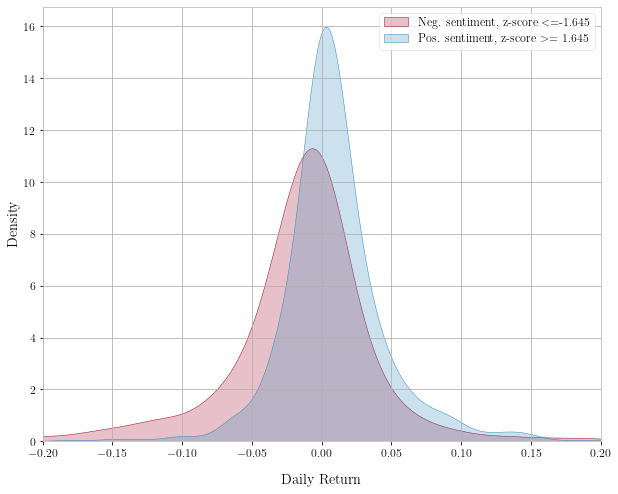

In [28]:
filename = "r_dist_pos_pos_neg_neg_2002-2020"

fig, ax = plt.subplots(figsize=(10,8))
sns.kdeplot(data=data_conditional[1.645][['Case_1', 'Case_2']], common_norm=False, fill=True, cumulative=False, legend=False, bw_adjust=1, gridsize=1000)
plt.xlim(-0.2, 0.2)
plt.legend(loc='upper right', labels=['Neg. sentiment, z-score $<=$ -1.645', 'Pos. sentiment, z-score $>=$  1.645'])
plt.xlabel('Daily Return', labelpad=15)
if export:
     plt.savefig(save_path+filename+'_'+datetime.now().strftime("%Hh%Mm%Ss")+'.pdf', dpi=100, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

Case 3: Positive sentiment & negative z-score  
Case 4: Negaitve sentiment & positive z-score

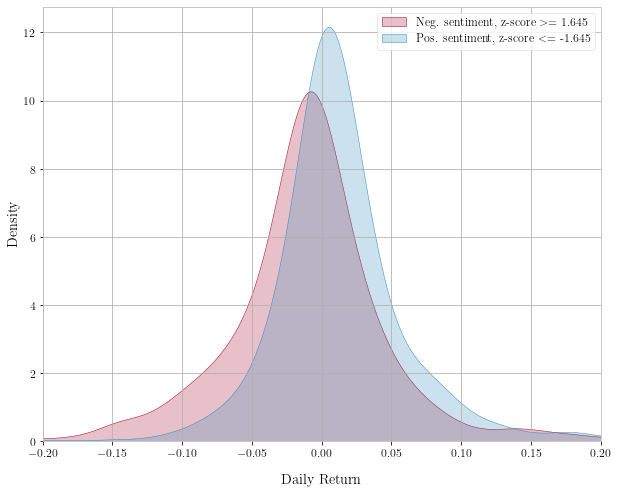

In [26]:
filename = "r_dist_pos_neg_neg_pos_2002-2020"

fix, ax = plt.subplots(figsize=(10,8))
sns.kdeplot(data=data_conditional[1.645][['Case_3', 'Case_4']], common_norm=False, fill=True, cumulative=False, legend=False, bw_adjust=1, gridsize=1000)
plt.xlim(-0.2, 0.2)
plt.legend(loc='upper right', labels=['Neg. sentiment, z-score $>=$  1.645', 'Pos. sentiment, z-score $<=$ -1.645'])
plt.xlabel('Daily Return', labelpad=15)
if export:
     plt.savefig(save_path+filename+'_'+datetime.now().strftime("%Hh%Mm%Ss")+'.pdf', dpi=100, facecolor='w', edgecolor='w', orientation='portrait')
plt.show()

Case 5: Positive Sentiment  
Case 6: Negative Sentiment

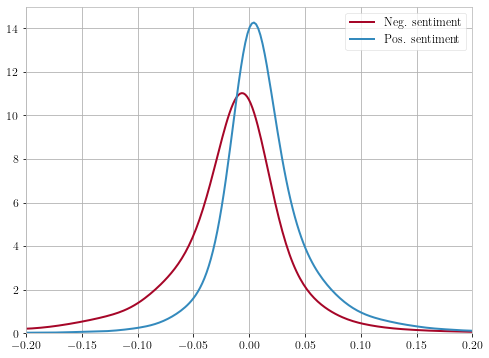

In [26]:
filename = "r_dist_pos_neg_2002-2020"

fix, ax = plt.subplots(figsize=(8,6))
sns.kdeplot(data=data_conditional[1.645][['Case_5', 'Case_6']], common_norm=False, fill=False, cumulative=False, legend=False, bw_adjust=1.8, linewidth=2, gridsize=1000)
plt.xlim(-0.2, 0.2)
plt.legend(loc='upper right', labels=['Neg. sentiment', 'Pos. sentiment'])
#plt.xlabel('Daily Return', labelpad=15)
plt.ylabel('')
if export:
     plt.savefig(save_path+filename+'_'+datetime.now().strftime("%Hh%Mm%Ss")+'.pdf', bbox_inches='tight')
plt.show()

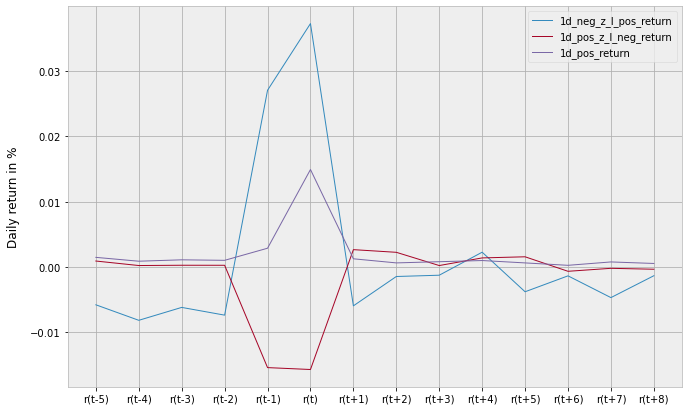

In [1087]:
x_values   = ['r(t-5)', 'r(t-4)', 'r(t-3)', 'r(t-2)', 'r(t-1)', 'r(t)', 'r(t+1)', 'r(t+2)', 'r(t+3)', 'r(t+4)', 'r(t+5)', 'r(t+6)', 'r(t+7)', 'r(t+8)']
linestyles = {1:'-', 2:'--', 3:'-.', 4:':', 5:'-', 6:'--', 7:'-.', 8:':', 9:'-', 10:'--', 11:'-.'}

plot_return_df = pd.DataFrame(columns=['1d_neg_z_I_pos_return', '1d_pos_z_I_neg_return'])

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(11,7))

# Positive news on day t
plot_return_df['1d_pos_return'] = pred_return_df.loc[(pred_return_df[recent_period] >= barrier), r_cols].mean(axis=0)

# Negative news on day t and significantely positive z-value on day t-1 at market close -------------------------------------
plot_return_df['1d_neg_z_I_pos_return'] = pred_return_df.loc[(pred_return_df[recent_period] <= -barrier)      &
                                                             (pred_return_df.z_value_t_I    >= z_val_barrier), r_cols].mean(axis=0)


# Negative news on day t and significantely negative z-value on day t-1 at market close -------------------------------------
plot_return_df['1d_pos_z_I_neg_return'] = pred_return_df.loc[(pred_return_df[recent_period] >= barrier)      &
                                                             (pred_return_df.z_value_t_I    <= -z_val_barrier), r_cols].mean(axis=0)


plot_return_df.index = x_values
plt.plot(x_values, plot_return_df, linewidth=1.0, label=plot_return_df.columns)
axs.set_ylabel('Daily return in %', labelpad=10)
plt.legend()
plt.show()

### 
Track statistics over multiple periods

In [1068]:
class calc_stats_over_periods():
    
    def __init__(self, params):
        """
        return_t_1 ... We consider the return from market open to market open on day t+1
        barrier    ... predicted_sentiment >= barrier -> positive (long) | predicted_sentiment <= barrier -> negative (short)
        predictive_var ... The predictive variables is either the financial news sentiment (news_sentiment), or the positive 
                           (or negative) z-values at market open (or close) e.g. z_values_neg_moo
        """
        self.params = params
        if params['predictive_var'] == 'news_sentiment':
            self.event_df = construct_df(params['trade_time'])   
        elif params['predictive_var'] == 'z_values_neg_moo':
            
          
    
    def select_strategy(self): 
        """
        Select a strategy:
        1d_neg_z_I_pos_return ... Negative news on day t and significantely positive z-value on day t-1 at market close 
        1d_neg_z_return       ... Negative news on day t and significantely negative z-value on day t
        """
        if self.params['trade_time'] == 'MOO':
            recent_period = 'prediction_value_t_mch'
        elif self.params['trade_time'] == 'MOC':    
            recent_period = 'prediction_value_t_moh'   
       
        if self.strategy == '1d_neg_return':
            self.subset_df = self.pred_return_df.loc[(self.pred_return_df[recent_period] <= -self.params['barrier']), self.params['return_val']]

        if self.strategy == '1d_pos_return':
            self.subset_df = self.pred_return_df.loc[(self.pred_return_df[recent_period] >= self.params['barrier']), self.params['return_val']]
    
        if self.strategy == '1d_neg_z_return':
            self.subset_df = self.pred_return_df.loc[(self.pred_return_df[recent_period] <= -self.params['barrier']) &
                                                     (self.pred_return_df.z_value_t      <= -self.params['z_val_barrier']), self.params['return_val']]

        if self.strategy == '1d_neg_z_I_pos_return':
            self.subset_df = self.pred_return_df.loc[(self.pred_return_df[recent_period] <= -self.params['barrier']) &
                                                     (self.pred_return_df.z_value_t_I    >= self.params['z_val_barrier']), self.params['return_val']]

        if self.strategy == 'neg_z_return':
            self.subset_df = self.pred_return_df.loc[(self.pred_return_df.z_value_t <= -self.params['z_val_barrier']), self.params['return_val']]

        if self.strategy == 'pos_z_return':
            self.subset_df = self.pred_return_df.loc[(self.pred_return_df.z_value_t >= self.params['z_val_barrier']), self.params['return_val']]
                   
            

    def get_df_slice(self, df, i, cols):
        return df.loc[((datetime.combine(self.dates[i-1], time(16,0)) <= df.index) & (df.index < datetime.combine(self.dates[i], time(16,0)))), cols]


    def merge_predictions(self, df, i, date):
        df_t_II = self.get_df_slice(df, i,   cols=['Ticker', 'period', 'prediction_value'])
        df_t_I  = self.get_df_slice(df, i+1, cols=['Ticker', 'period', 'prediction_value'] )
        df_t    = self.get_df_slice(df, i+2, cols=['Ticker', 'period', 'z_value_t_I', 'z_value_t'] + r_cols + ['prediction_value'])


        if self.params['trade_time'] == 'MOO':
            df_vals_t = df_t.loc[df_t.period=='mc_to_mo'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_mch'})

        elif self.params['trade_time'] == 'MOC':
            df_vals_t = pd.merge(left  = df_t.loc[df_t.period=='mo_to_mc'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_moh'}),
                                 right = df_t.loc[df_t.period=='mc_to_mo', ['Ticker', 'prediction_value']].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_mch'}), 
                                 left_index  = True,
                                 right_index = True, 
                                 how = 'outer')

        df_vals_t_I  = pd.merge(left  = df_t_I.loc[df_t_I.period=='mo_to_mc'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_I_moh'}),
                                right = df_t_I.loc[df_t_I.period=='mc_to_mo'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_I_mch'}), 
                                left_index  = True,
                                right_index = True, 
                                how = 'outer')

        df_vals_t_tI = pd.merge(left=df_vals_t, right=df_vals_t_I, left_index=True, right_index=True, how='left')

        df_vals_t_II = pd.merge(left  = df_t_II.loc[df_t_II.period=='mo_to_mc'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_II_moh'}),
                                right = df_t_II.loc[df_t_II.period=='mc_to_mo'].groupby('Ticker').mean().rename(columns={'prediction_value':'prediction_value_t_II_mch'}), 
                                left_index  = True,
                                right_index = True, 
                                how = 'outer')

        return pd.merge(left=df_vals_t_tI, right=df_vals_t_II, left_index=True, right_index=True, how='left')

   
    
    
    def run(self, strategy_name, start_date, end_date):
        self.strategy  = strategy_name
        self.return_df = pd.DataFrame(columns=[strategy_name])
        
        df = self.event_df.sel_period(start_date, end_date)
        self.dates = pd.DatetimeIndex(df.Date.unique())
                
        for i, date in enumerate(self.dates[1:-2]):
            # Merge the predictions of market opening and market closing periods into one dataframe
            self.pred_return_df = self.merge_predictions(df, i, date)
                                                
            # Apply a strategy and select the corresponding subset dataframe
            self.select_strategy()
            
            self.returns_t = pd.DataFrame()
            self.returns_t[strategy_name] = self.subset_df.dropna().values
            self.returns_t['date'] = date
            self.returns_t.set_index('date', inplace=True)

            self.return_df = pd.concat([self.return_df, self.returns_t], axis=0)
            
            
params = {'return_val':   'return_t_1',
          'barrier':       0.95,
          'z_val_barrier': 1.96,
          'trade_time':    'MOO'
}

stats_over_periods = calc_stats_over_periods(params)

In [1069]:
stats_over_periods.run(strategy_name = 'pos_z_return',
                       start_date    = date(2002,1,1),
                       end_date      = date(2020,1,1))   

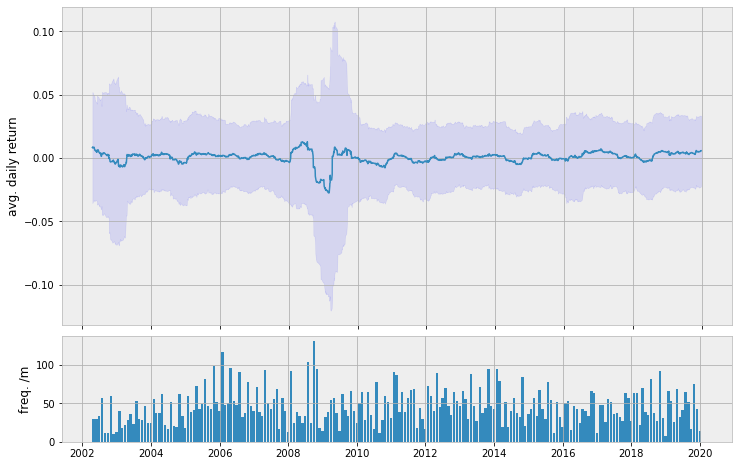

In [1071]:
ma = '180D'
dates = stats_over_periods.return_df.index[90:]
smooth_path    = stats_over_periods.return_df[stats_over_periods.strategy].rolling(ma).mean().resample('B').mean()[dates]
path_deviation = stats_over_periods.return_df[stats_over_periods.strategy].rolling(ma).std().resample('B').mean()[dates]

under_line     = (smooth_path-path_deviation)
over_line      = (smooth_path+path_deviation)

stats_over_periods.return_df['count'] = 1
freq = stats_over_periods.return_df['count'].resample('BM').sum().loc[dates[0]:]

fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(12,8), gridspec_kw={'height_ratios': [3, 1]})
plt.subplots_adjust(hspace = 0.05)
ax0.plot(smooth_path, linewidth=1.5) 
ax0.fill_between(path_deviation.index, under_line, over_line, color='b', alpha=.1) 
ax0.set_ylabel('avg. daily return')
ax0.xaxis.set_ticklabels([])
ax1.bar(freq.index, freq, width=25)
ax1.set_ylabel('freq. /m')
#plt.savefig(f'C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/Bilder/return_ts_strategy_{stats_over_periods.strategy}_ma_{ma}.pdf', bbox_inches='tight')
plt.show()

In [225]:
df_neg     = df[((df['z_value_t'] < -1.96) & (df['Prediction'] == 1))]
ticker_neg = list(df_neg.index.get_level_values(0))    # list of tickers where negative news co-occur with negative z-values

print(ticker_neg[-1000:-950])

['AKAM', 'ANTM', 'ANTM', 'WYNN', 'BAX', 'FFIV', 'MPC', 'PSA', 'JCI', 'IP', 'MMC', 'MCK', 'BMY', 'SBUX', 'SBUX', 'AMZN', 'GT', 'BEN', 'DISCA', 'ECL', 'CMI', 'PXD', 'PXD', 'AN', 'VMC', 'CAH', 'CHD', 'DISH', 'CNP', 'ABC', 'VIAB', 'NWL', 'IT', 'DIS', 'XRAY', 'NVDA', 'AAP', 'CSCO', 'CSCO', 'DE', 'MDT', 'COTY', 'SYK', 'SJM', 'ULTA', 'ULTA', 'HRB', 'CPB', 'GS', 'NWL']


In [67]:
## Filter for topics ##
#df = filter_topic(df, topic='topic_1')
#######################

## Filter for z-values ##
#df = df[((df['z_value_t'] < -1.96) & (df['Prediction'] == 1))]
#########################

#df = df.loc[abs(df.prediction_value) >= 0.95, :]  # control prediction confidence

In [46]:
def plot_events_chart(ticker_price_index, ticker_news, year):
    fix, ax = plt.subplots(figsize=(18,4))
    sns.lineplot(data=ticker_price_index, linewidth=1)

    for i in ticker_news.index:
        if ticker_news.loc[i, 'Prediction'] == 1:
            if ticker_news.loc[i, 'z_value_t'] <= -1.96:
                c = 'r'
            else:
                c = 'm'
        else:
            c = 'g'
        plt.axvline(ticker_news.Timestamp_ET[i], color=c, linestyle='--', linewidth=0.5)

    plt.xticks(rotation=45)
    plt.title(year)
    plt.show()

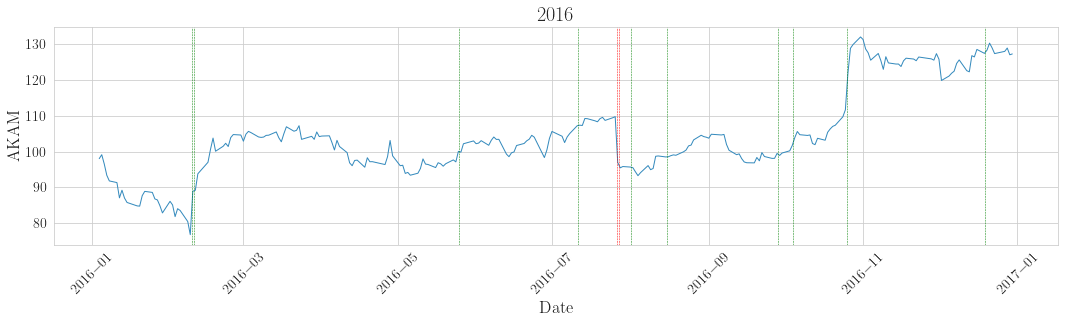

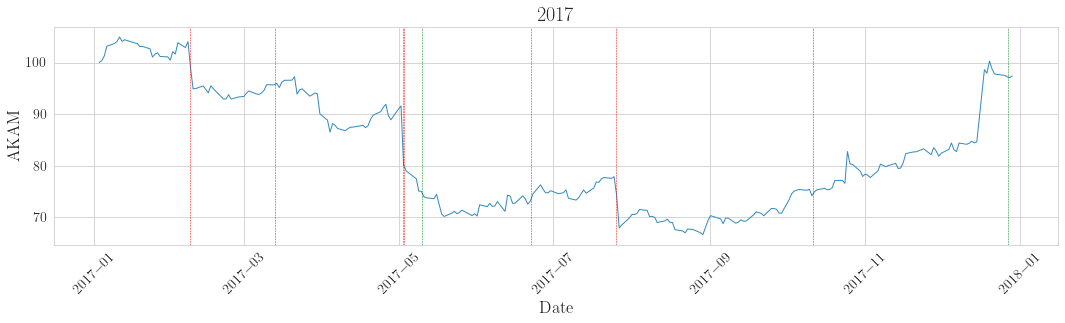

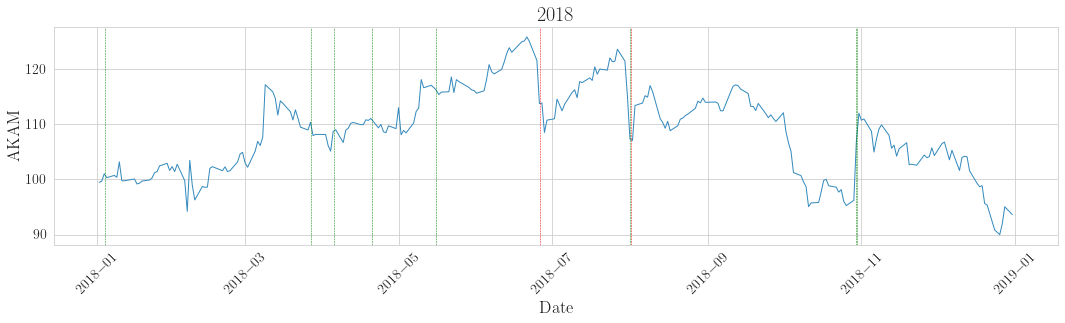

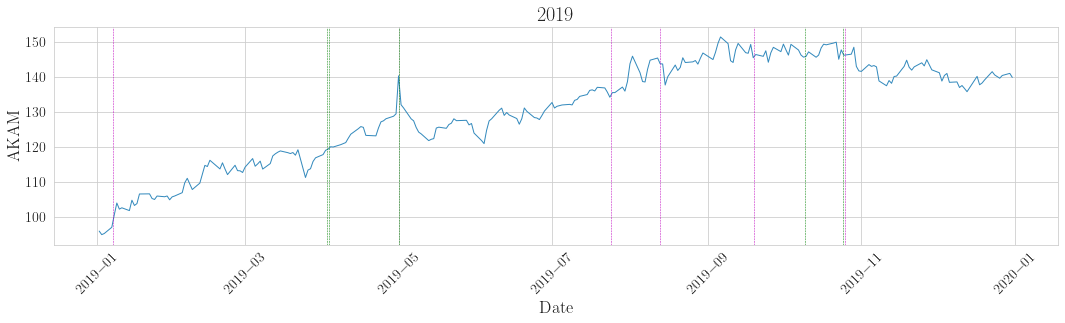

In [234]:
ticker = 'AKAM'
years  = [2016, 2017, 2018, 2019]

for year in years:
    ticker_news = test_data_pred.loc[(ticker, test_data_pred.index.get_level_values('Date').year == year), :].droplevel('Ticker')
    ticker_news.Timestamp_ET = pd.to_datetime(ticker_news.Timestamp_ET)
    ticker_news = ticker_news.reset_index(drop=True)
    ticker_news = ticker_news.set_index(ticker_news.Timestamp_ET)

    ticker_returns = return_data.loc[return_data.index.year==year, ticker]
    ticker_price_index = (ticker_returns+1).cumprod()*100
    
    plot_events_chart(ticker_price_index, ticker_news, year)

## 
### Export Data Frames to LATEX

In [15]:
cr = classification_report(up_down_predictions.y_true, up_down_predictions.predict_direction, output_dict=True, zero_division=0)
cr_df = pd.DataFrame.from_dict(cr)
cr_df = cr_df.rename(columns={'1.0':'Neg. pred.', '2.0':'Pos. pred.'})
#cr_df = cr_df.drop(columns=['0.0'])

cr_df.loc['Avg. return (t+1) p.a.', 'Pos. pred.'] = pos_mean_return
cr_df.loc['Avg. return (t+1) p.a.', 'Neg. pred.'] = neg_mean_return

cr_df.round(4)

In [ ]:
# Write df to latex
with open('C:/Users/Stefa/Documents/Uni/Projektassistenz/Auswertung/Tabellen/classification_report_conf_95_topic_1_z_val_neg_95.tex','w') as tf:
    tf.write(cr_df.round(4).to_latex()) 